In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise, Embedding, multiply, concatenate, add
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [3]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [4]:
train_imgs = []
train_classes = []
class_index = 0
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    print(f'{len(files)} samples in class {class_index}, ({root})')
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))
        train_classes.append(class_index)
    class_index += 1
train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5
train_imgs = train_imgs.astype(np.float32)
train_classes = np.array(train_classes)

60 samples in class 0, (./CUB_200_2011/CUB_200_2011/images-cleaned/001.Black_footed_Albatross)
60 samples in class 1, (./CUB_200_2011/CUB_200_2011/images-cleaned/002.Laysan_Albatross)
58 samples in class 2, (./CUB_200_2011/CUB_200_2011/images-cleaned/003.Sooty_Albatross)
60 samples in class 3, (./CUB_200_2011/CUB_200_2011/images-cleaned/004.Groove_billed_Ani)
44 samples in class 4, (./CUB_200_2011/CUB_200_2011/images-cleaned/005.Crested_Auklet)
41 samples in class 5, (./CUB_200_2011/CUB_200_2011/images-cleaned/006.Least_Auklet)
53 samples in class 6, (./CUB_200_2011/CUB_200_2011/images-cleaned/007.Parakeet_Auklet)
48 samples in class 7, (./CUB_200_2011/CUB_200_2011/images-cleaned/008.Rhinoceros_Auklet)
59 samples in class 8, (./CUB_200_2011/CUB_200_2011/images-cleaned/009.Brewer_Blackbird)
60 samples in class 9, (./CUB_200_2011/CUB_200_2011/images-cleaned/010.Red_winged_Blackbird)
60 samples in class 10, (./CUB_200_2011/CUB_200_2011/images-cleaned/011.Rusty_Blackbird)
56 samples in cla

60 samples in class 94, (./CUB_200_2011/CUB_200_2011/images-cleaned/095.Baltimore_Oriole)
60 samples in class 95, (./CUB_200_2011/CUB_200_2011/images-cleaned/096.Hooded_Oriole)
59 samples in class 96, (./CUB_200_2011/CUB_200_2011/images-cleaned/097.Orchard_Oriole)
60 samples in class 97, (./CUB_200_2011/CUB_200_2011/images-cleaned/098.Scott_Oriole)
60 samples in class 98, (./CUB_200_2011/CUB_200_2011/images-cleaned/099.Ovenbird)
60 samples in class 99, (./CUB_200_2011/CUB_200_2011/images-cleaned/100.Brown_Pelican)
50 samples in class 100, (./CUB_200_2011/CUB_200_2011/images-cleaned/101.White_Pelican)
60 samples in class 101, (./CUB_200_2011/CUB_200_2011/images-cleaned/102.Western_Wood_Pewee)
60 samples in class 102, (./CUB_200_2011/CUB_200_2011/images-cleaned/103.Sayornis)
60 samples in class 103, (./CUB_200_2011/CUB_200_2011/images-cleaned/104.American_Pipit)
49 samples in class 104, (./CUB_200_2011/CUB_200_2011/images-cleaned/105.Whip_poor_Will)
60 samples in class 105, (./CUB_200_20

50 samples in class 186, (./CUB_200_2011/CUB_200_2011/images-cleaned/187.American_Three_toed_Woodpecker)
60 samples in class 187, (./CUB_200_2011/CUB_200_2011/images-cleaned/188.Pileated_Woodpecker)
60 samples in class 188, (./CUB_200_2011/CUB_200_2011/images-cleaned/189.Red_bellied_Woodpecker)
58 samples in class 189, (./CUB_200_2011/CUB_200_2011/images-cleaned/190.Red_cockaded_Woodpecker)
60 samples in class 190, (./CUB_200_2011/CUB_200_2011/images-cleaned/191.Red_headed_Woodpecker)
60 samples in class 191, (./CUB_200_2011/CUB_200_2011/images-cleaned/192.Downy_Woodpecker)
60 samples in class 192, (./CUB_200_2011/CUB_200_2011/images-cleaned/193.Bewick_Wren)
60 samples in class 193, (./CUB_200_2011/CUB_200_2011/images-cleaned/194.Cactus_Wren)
60 samples in class 194, (./CUB_200_2011/CUB_200_2011/images-cleaned/195.Carolina_Wren)
59 samples in class 195, (./CUB_200_2011/CUB_200_2011/images-cleaned/196.House_Wren)
60 samples in class 196, (./CUB_200_2011/CUB_200_2011/images-cleaned/197.M

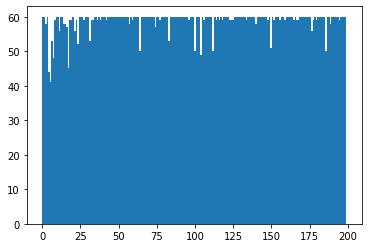

(11788, 64, 64, 3)


In [5]:
plt.hist(train_classes, bins=200)
plt.show()
assert(len(train_imgs) == len(train_classes))
print(train_imgs.shape)

In [5]:
def create_simple_attrs(attrs):
    # Structure is like so: [0-14:color, 15-19:size, 20-33:shape]

    simple_attrs = np.zeros((attrs.shape[0], 34))
    
    # Color
    simple_attrs[:, 0:15] = attrs[:, 248:263]
    
    # Size and shape
    simple_attrs[:, 15:34] = attrs[:, 217:236]
    
    return simple_attrs


In [6]:
def create_even_simpler_attrs(attrs):
    # Structure is like so: [0-4:color, 5-7:size, 8-9:shape]
    
    simplest_attrs = np.zeros((attrs.shape[0], 10))
    
    simplest_attrs[:, 0] = attrs[:, 1] # Brown
    simplest_attrs[:, 1] = attrs[:, 5] # Grey
    simplest_attrs[:, 2] = attrs[:, 11] # Black
    simplest_attrs[:, 3] = attrs[:, 12] # White
    simplest_attrs[:, 4] = np.clip(np.sum(attrs[:, [0, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14]], axis=1), a_min=0, a_max=1) # Other
    
    simplest_attrs[:, 5] = attrs[:, 19] # Smallest
    simplest_attrs[:, 6] = attrs[:, 16] # Small
    simplest_attrs[:, 7] = np.clip(np.sum(attrs[:, [15, 17, 18]], axis=1), a_min=0, a_max=1) # Large
    
    simplest_attrs[:, 8] = attrs[:, 33] # Perching-like
    simplest_attrs[:, 9] = np.clip(np.sum(attrs[:, [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]], axis=1), a_min=0, a_max=1) # Not perching-like
    
    return simplest_attrs

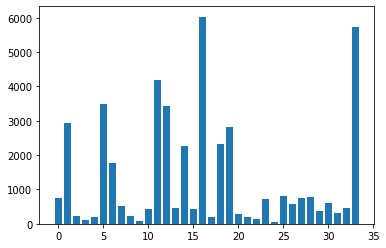

In [7]:
def load_image_attributes():
    train_attrs = np.zeros((train_imgs.shape[0], 312))
    with open('./CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            
            # For now we don't care about attribute certainty, just if it is present.
            try:
                split = line.split()
                img_id = int(split[0])
                assert(img_id > 0)
                assert(img_id <= 11788)
                attr_id = int(split[1])
                assert(attr_id > 0)
                assert(attr_id <= 312)
                is_present = int(split[2])
                assert(is_present == 0 or is_present == 1)
            except: 
                print(line)
                print(line.split())
                return
            
            train_attrs[img_id-1, attr_id-1] = is_present
    return train_attrs

train_attrs = load_image_attributes().astype('float32')
train_attrs = create_simple_attrs(train_attrs)
plt.bar([x for x in range(34)], np.sum(train_attrs, axis=0))
plt.show()
train_attrs = create_even_simpler_attrs(train_attrs)
train_attrs = train_attrs.astype(np.float32)

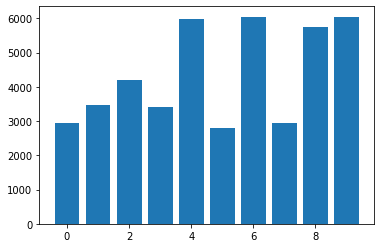

4358.4
1349.5349


In [8]:
plt.bar([x for x in range(10)], np.sum(train_attrs, axis=0))
plt.show()
sum_attrs = np.sum(train_attrs, axis=0)

print(np.mean(sum_attrs))
print(np.std(sum_attrs))
# np.argmin(sum_attrs)

In [9]:
def make_generator_model(shape):
    
    noise_in = Input(shape=shape)
    attributes_in = Input(shape=(10,))
    
    input_layer = concatenate([noise_in, attributes_in])
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, attributes_in], x)

In [10]:
generator = make_generator_model((300,))
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 310)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32768)        10190848    concatenate[0][0]            

(10,)


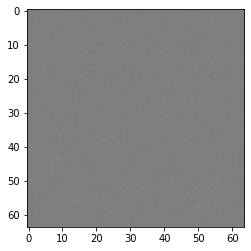

In [11]:
generator = make_generator_model((300,))

noise = np.random.normal(0, 1, 300)
label = train_attrs[0]
print(label.shape)

generated_image = generator.predict( [np.array([noise]), np.array([label])] )[0]
plt.imshow(unnormalize_img(generated_image), )

In [12]:
def make_valid_discriminator_model():
    input_layer = Input((64, 64, 3))
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='valid')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x) 
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    
    return Model(input_layer, valid)

In [13]:
discriminator_valid = make_valid_discriminator_model()
discriminator_valid.summary()
valid = discriminator_valid.predict(np.array([generated_image]))


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
valid (Conv2D)               (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0   

In [14]:
def make_attr_discriminator_model():
    input_layer = Input((64, 64, 3))
    
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', name='attr')(input_layer)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)

    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)


#     x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    x = Dense(32)(x)
    x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    attr = Dense(10, activation='sigmoid')(x)
    
    return Model(input_layer, attr)

In [15]:
discriminator_attr = make_attr_discriminator_model()
discriminator_attr.summary()
attrs = discriminator_attr.predict(np.array([generated_image]))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
attr (Conv2D)                (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 64)        0   

In [18]:
cross_entropy = BinaryCrossentropy(from_logits=False)

@tf.function
def discriminator_valid_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [19]:
# mse = MeanSquaredError()

@tf.function
def discriminator_attribute_loss_real(real_output, real_attributes):
    return cross_entropy(real_output, real_attributes)

@tf.function
def discriminator_attribute_loss_fake(fake_output, fake_attributes):
    return cross_entropy(fake_output, fake_attributes)

In [20]:
@tf.function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def generator_attr_loss(fake_attr_output, sampled_attrs):
#     tf.print(fake_attr_output[0], summarize=10)
#     tf.print(sampled_attrs[0], summarize=10, end='\n\n')
    return cross_entropy(fake_attr_output, sampled_attrs)

In [21]:
@tf.function
def train_step(images, attrs, sampled_attrs, flip, warmup):
    noise = tf.random.truncated_normal([32, 300], dtype=tf.dtypes.float64)
    
#     sampled_attrs = tf.cast(tf.random.uniform([32, 312], minval=0, maxval=2, dtype='int32'), 'float32') # Need to make this smarter. Only one 1 per attr.
    
#     attrs = tf.reshape(attrs, (attrs.shape[0], 1))
    
    gen_losses = []
    gen_valid_losses = []
    gen_attr_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    disc_attr_real_losses = []
    disc_attr_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_valid, tf.GradientTape() as disc_tape_attr:
        generated_images = generator([noise, sampled_attrs], training=True)
        
        real_output = discriminator_valid(images, training=True)
        fake_output = discriminator_valid(generated_images, training=True)
        
        real_attr_output = discriminator_attr(images, training=True)
        fake_attr_output = discriminator_attr(generated_images, training=True)
        
        gen_valid_loss = generator_loss(fake_output)
        gen_attr_loss = generator_attr_loss(fake_attr_output, sampled_attrs)
        gen_loss = ((2.0 - warmup) * gen_valid_loss + (warmup * gen_attr_loss))
        
        disc_valid_loss, disc_real_loss, disc_fake_loss = discriminator_valid_loss(real_output, fake_output, flip)
        disc_attr_real_loss = discriminator_attribute_loss_real(real_attr_output, attrs)
        disc_attr_fake_loss = discriminator_attribute_loss_fake(fake_attr_output, sampled_attrs)
        disc_attr_loss = ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
#         disc_loss += ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
        
        
        gen_losses.append(K.mean(gen_loss))
        gen_valid_losses.append(K.mean(gen_valid_loss))
        gen_attr_losses.append(K.mean(gen_attr_loss))
        disc_losses.append(K.mean(disc_valid_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))
        disc_attr_real_losses.append(K.mean(disc_attr_real_loss))
        disc_attr_fake_losses.append(K.mean(disc_attr_fake_loss))
    
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator_valid = disc_tape_valid.gradient(disc_valid_loss, discriminator_valid.trainable_variables)
    
    gradients_of_discriminator_attr = disc_tape_attr.gradient(disc_attr_loss, discriminator_attr.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_valid_optimizer.apply_gradients(zip(gradients_of_discriminator_valid, discriminator_valid.trainable_variables))
    
    discriminator_attr_optimizer.apply_gradients(zip(gradients_of_discriminator_attr, discriminator_attr.trainable_variables))

    return (gen_losses, gen_valid_losses, gen_attr_losses, disc_losses, disc_real_losses, disc_fake_losses, disc_attr_real_losses, disc_attr_fake_losses)

In [22]:
def train(train_imgs, train_attrs, epochs, warmup):
    gen_loss_all = []
    gen_valid_loss_all = []
    gen_attr_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    disc_attr_loss_real_all = []
    disc_attr_loss_fake_all = []
    warmup_step = 1./2000.
    
    num_samples = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        gen_valid_loss_epoch = [1, 0]
        gen_attr_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        disc_attr_loss_real_epoch = [1, 0]
        disc_attr_loss_fake_epoch = [1, 0]
        
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        np.random.shuffle(train_imgs)
        np.random.seed(seed)
        np.random.shuffle(train_attrs)
        
        for idx, i in enumerate(range(0, num_samples - 32, 32)):
            
            gen_loss_batch, gen_valid_loss_batch, gen_attr_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch, disc_attr_loss_real_batch, disc_attr_loss_fake_batch = train_step(train_imgs[i:(i+32)], train_attrs[i:(i+32)], train_attrs[np.random.choice(range(len(train_attrs)), 32, replace=False)], batch_counter % 20 == 0, tf.constant(warmup, dtype='float32'))

            gen_loss_epoch[0] += 1
            gen_valid_loss_epoch[0] += 1
            gen_attr_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            disc_attr_loss_real_epoch[0] += 1
            disc_attr_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            gen_valid_loss_epoch[1] += np.mean(gen_valid_loss_batch)
            gen_attr_loss_epoch[1] += np.mean(gen_attr_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            disc_attr_loss_real_epoch[1] += np.mean(disc_attr_loss_real_batch)
            disc_attr_loss_fake_epoch[1] += np.mean(disc_attr_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Gen valid loss: {gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0]}, Gen attr loss: {gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0]}, Disc valid loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc valid real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc valid fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}, Disc attr loss: {(disc_attr_loss_real_epoch[1] + disc_attr_loss_fake_epoch[1])/(disc_attr_loss_real_epoch[0])}, Disc attr real loss: {disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0]}, Disc attr fake loss: {disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        gen_valid_loss_all.append(gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0])
        gen_attr_loss_all.append(gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
        disc_attr_loss_real_all.append(disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0])
        disc_attr_loss_fake_all.append(disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0])
        
        if warmup < 1:
            warmup += warmup_step
    
    return (gen_loss_all, gen_valid_loss_all, gen_attr_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all, disc_attr_loss_real_all, disc_attr_loss_fake_all, warmup)
    


In [23]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, g_valid_hist=None, g_attr_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, d_attr_real_hist=None, d_attr_fake_hist=None, noise=None, attr=None, save_files=False, warmup=0.):

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, gen_valid_temp, gen_attr_temp, disc_temp, disc_real_temp, disc_fake_temp, disc_attr_real_temp, disc_attr_fake_temp, warmup = train(train_imgs, train_attrs, checkpoint_interval, warmup)
        
        g_hist += gen_temp
        g_valid_hist += gen_valid_temp
        g_attr_hist += gen_attr_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        d_attr_real_hist += disc_attr_real_temp
        d_attr_fake_hist += disc_attr_fake_temp
        generated_image = generator.predict( [np.array([noise]), np.array([attr])])[0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/bird-gan-attributes-split-sigmoid-simple-tuning/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning/gen_weights_attributes_split_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_valid.save_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning/disc_weights_attributes_split_valid_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_attr.save_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning/disc_weights_attributes_split_attr_' + str((i+1)*checkpoint_interval) + '.h5')
    
    return starting_checkpoint + num_checkpoints, totalepochs, warmup

In [24]:
discriminator_valid = make_valid_discriminator_model()
discriminator_attr = make_attr_discriminator_model()
generator = make_generator_model((300,))
generator_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_valid_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_attr_optimizer = Adam(1e-4, beta_1=0.5)

In [25]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
gen_valid_loss_hist = []
gen_attr_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
disc_attr_loss_real_hist = []
disc_attr_loss_fake_hist = []
noise300 = np.random.normal(0, 1, 300)
attr = train_attrs[0]
next_starting_checkpoint = 0
totalepochs = 0
warmup = 0.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 20

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 33.20090961456299 sec
Gen loss: 1.4643001049191648, Gen valid loss: 1.4155222600714623, Gen attr loss: 0.048777843621118366, Disc valid loss: 1.0350028279674086, Disc valid real loss: 0.5316190743026371, Disc valid fake loss: 0.5033837548762479, Disc attr loss: 1.0554721952141255, Disc attr real loss: 1.0066943515930071, Disc attr fake loss: 0.048777843621118366
Time for epoch 2 is 33.6011917591095 sec
Gen loss: 1.4726423548489083, Gen valid loss: 1.4262288039938866, Gen attr loss: 0.04710306123231823, Disc valid loss: 1.0264196507329864, Disc valid real loss: 0.5232136954621571, Disc valid fake loss: 0.5032059554323595, Disc attr loss: 1.0577442613418673, Disc attr real loss: 1.010641200109549, Disc attr fake loss: 0.04710306123231823
Time for epoch 3 is 33.59718155860901 sec
Gen loss: 1.4530433542360135, Gen valid loss: 1.3990979843992528, Gen attr 

Time for epoch 23 is 35.319204807281494 sec
Gen loss: 1.4722307484324386, Gen valid loss: 1.4214055137582589, Gen attr loss: 0.0515101325503815, Disc valid loss: 1.029606135233954, Disc valid real loss: 0.5231963917007291, Disc valid fake loss: 0.5064097442601109, Disc attr loss: 1.0505166600188225, Disc attr real loss: 0.999006527468441, Disc attr fake loss: 0.0515101325503815
Time for epoch 24 is 34.57681584358215 sec
Gen loss: 1.4689061262097138, Gen valid loss: 1.430062814941251, Gen attr loss: 0.03953852697701079, Disc valid loss: 1.027000896168272, Disc valid real loss: 0.5296039511840841, Disc valid fake loss: 0.4973969444188322, Disc attr loss: 1.0396214848508334, Disc attr real loss: 1.0000829578738226, Disc attr fake loss: 0.03953852697701079
Time for epoch 25 is 34.90261769294739 sec
Gen loss: 1.444260158189913, Gen valid loss: 1.3979415467114953, Gen attr loss: 0.04699403600625952, Disc valid loss: 1.0354601241708772, Disc valid real loss: 0.5317937873889437, Disc valid fak

Time for epoch 45 is 35.07979917526245 sec
Gen loss: 1.4756734978538866, Gen valid loss: 1.4282927322516918, Gen attr loss: 0.04807082581093494, Disc valid loss: 1.023053440782759, Disc valid real loss: 0.5262320314642537, Disc valid fake loss: 0.4968214112568677, Disc attr loss: 1.0450161283910422, Disc attr real loss: 0.9969453025801072, Disc attr fake loss: 0.04807082581093494
Time for epoch 46 is 34.38213491439819 sec
Gen loss: 1.4722267310147685, Gen valid loss: 1.4291847658351184, Gen attr loss: 0.04373464341804358, Disc valid loss: 1.0324674289077924, Disc valid real loss: 0.5275097483703437, Disc valid fake loss: 0.5049576777914352, Disc attr loss: 1.0386487764692671, Disc attr real loss: 0.9949141330512236, Disc attr fake loss: 0.04373464341804358
Time for epoch 47 is 34.14629077911377 sec
Gen loss: 1.4784554175245084, Gen valid loss: 1.4294136000196462, Gen attr loss: 0.049731611724337356, Disc valid loss: 1.0231311870461235, Disc valid real loss: 0.5235203486794056, Disc val

Time for epoch 67 is 34.03276300430298 sec
Gen loss: 1.4675584033252747, Gen valid loss: 1.4249953134919247, Gen attr loss: 0.04325391214689804, Disc valid loss: 1.022337722422954, Disc valid real loss: 0.523244837919871, Disc valid fake loss: 0.49909288636068017, Disc attr loss: 1.0291679150590523, Disc attr real loss: 0.9859140029121544, Disc attr fake loss: 0.04325391214689804
Time for epoch 68 is 34.005658864974976 sec
Gen loss: 1.4777572804350194, Gen valid loss: 1.4308274406081616, Gen attr loss: 0.047621395721436505, Disc valid loss: 1.0231641931585502, Disc valid real loss: 0.5268411449785155, Disc valid fake loss: 0.4963230464032026, Disc attr loss: 1.0341091500366553, Disc attr real loss: 0.9864877543152186, Disc attr fake loss: 0.047621395721436505
Time for epoch 69 is 34.0147066116333 sec
Gen loss: 1.4711407778385854, Gen valid loss: 1.4209025167837375, Gen attr loss: 0.05092320257591232, Disc valid loss: 1.0295613710150162, Disc valid real loss: 0.5319609724409212, Disc va

Time for epoch 89 is 33.981008768081665 sec
Gen loss: 1.4655974932156282, Gen valid loss: 1.4145285194805322, Gen attr loss: 0.05175031445822781, Disc valid loss: 1.0310005789526755, Disc valid real loss: 0.5257621737838114, Disc valid fake loss: 0.5052384013729043, Disc attr loss: 1.0314761037874516, Disc attr real loss: 0.9797257893292238, Disc attr fake loss: 0.05175031445822781
Time for epoch 90 is 33.98766827583313 sec
Gen loss: 1.4552402596486615, Gen valid loss: 1.41189448071043, Gen attr loss: 0.044029668150004884, Disc valid loss: 1.0303721547449831, Disc valid real loss: 0.5289675550570656, Disc valid fake loss: 0.5014045979918503, Disc attr loss: 1.0242554543532962, Disc attr real loss: 0.9802257862032914, Disc attr fake loss: 0.044029668150004884
Time for epoch 91 is 33.99208950996399 sec
Gen loss: 1.438102456935376, Gen valid loss: 1.3966220252236055, Gen attr loss: 0.0421576128221006, Disc valid loss: 1.0392021107156748, Disc valid real loss: 0.5339278320309916, Disc vali

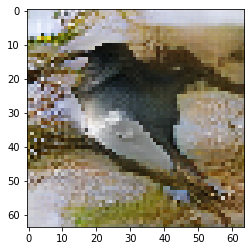

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 21

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 33.90818667411804 sec
Gen loss: 1.4776125862023373, Gen valid loss: 1.4299575074255304, Gen attr loss: 0.048345835473464924, Disc valid loss: 1.0306201242819064, Disc valid real loss: 0.5301683877864827, Disc valid fake loss: 0.5004517361723634, Disc attr loss: 1.025411167444884, Disc attr real loss: 0.9770653319714192, Disc attr fake loss: 0.048345835473464924
Time for epoch 2 is 34.13613963127136 sec
Gen loss: 1.445889334368512, Gen valid loss: 1.4090331922055583, Gen attr loss: 0.037541836657198104, Disc valid loss: 1.034308718956583, Disc valid real loss: 0.5313967734494507, Disc valid fake loss: 0.5029119446994813, Disc attr loss: 1.0148970994316373, Disc attr real loss: 0.9773552627744391, Disc attr fake loss: 0.037541836657198104
Time for epoch 3 is 33.881370306015015 sec
Gen loss: 1.4736569115139928, Gen valid loss: 1.4342109129680851, Gen att

Time for epoch 23 is 34.00086498260498 sec
Gen loss: 1.4465224154919467, Gen valid loss: 1.4025233841846951, Gen attr loss: 0.044677910527382576, Disc valid loss: 1.0365253218467319, Disc valid real loss: 0.5324191374345847, Disc valid fake loss: 0.5041061823122547, Disc attr loss: 1.017879293301384, Disc attr real loss: 0.9732013827740016, Disc attr fake loss: 0.044677910527382576
Time for epoch 24 is 34.032692432403564 sec
Gen loss: 1.4814418421851263, Gen valid loss: 1.434108371980145, Gen attr loss: 0.048026462988287826, Disc valid loss: 1.01984342440034, Disc valid real loss: 0.5230528830189692, Disc valid fake loss: 0.4967905409775452, Disc attr loss: 1.0193389510667128, Disc attr real loss: 0.971312488078425, Disc attr fake loss: 0.048026462988287826
Time for epoch 25 is 33.98156189918518 sec
Gen loss: 1.4647816290377278, Gen valid loss: 1.4268409821399182, Gen attr loss: 0.038634699630098884, Disc valid loss: 1.0250620745061858, Disc valid real loss: 0.5242751441027736, Disc va

Time for epoch 45 is 34.04178071022034 sec
Gen loss: 1.4590491954550187, Gen valid loss: 1.4174108997916142, Gen attr loss: 0.04232578950354972, Disc valid loss: 1.0269116466930566, Disc valid real loss: 0.5223047839916819, Disc valid fake loss: 0.5046068635897908, Disc attr loss: 1.0070763159815237, Disc attr real loss: 0.964750526477974, Disc attr fake loss: 0.04232578950354972
Time for epoch 46 is 33.99342322349548 sec
Gen loss: 1.4550879302063608, Gen valid loss: 1.413854898476019, Gen attr loss: 0.041918949032027066, Disc valid loss: 1.037309914261991, Disc valid real loss: 0.5325024695738867, Disc valid fake loss: 0.5048074422651513, Disc attr loss: 1.0071683873049324, Disc attr real loss: 0.9652494382729052, Disc attr fake loss: 0.041918949032027066
Time for epoch 47 is 33.99477815628052 sec
Gen loss: 1.449269229803628, Gen valid loss: 1.4072734618251563, Gen attr loss: 0.04267801645158903, Disc valid loss: 1.0274136486415295, Disc valid real loss: 0.5245170875939573, Disc valid

Time for epoch 67 is 33.9954674243927 sec
Gen loss: 1.4649214366587198, Gen valid loss: 1.427964322289154, Gen attr loss: 0.037652216138760616, Disc valid loss: 1.0270203946405634, Disc valid real loss: 0.5274338566352358, Disc valid fake loss: 0.4995865405090456, Disc attr loss: 0.9997773782608099, Disc attr real loss: 0.9621251621220493, Disc attr fake loss: 0.037652216138760616
Time for epoch 68 is 33.99142146110535 sec
Gen loss: 1.4631722519391275, Gen valid loss: 1.422627333056959, Gen attr loss: 0.041235566238808787, Disc valid loss: 1.0319509314004645, Disc valid real loss: 0.5269311013098977, Disc valid fake loss: 0.5050198306559224, Disc attr loss: 1.0008657365660238, Disc attr real loss: 0.959630170327215, Disc attr fake loss: 0.041235566238808787
Time for epoch 69 is 33.99459266662598 sec
Gen loss: 1.4687698827526434, Gen valid loss: 1.4269591133768966, Gen attr loss: 0.042502949500613, Disc valid loss: 1.0230763145901647, Disc valid real loss: 0.5219568735377252, Disc valid

Time for epoch 89 is 34.08998513221741 sec
Gen loss: 1.4607830354514806, Gen valid loss: 1.425867884462765, Gen attr loss: 0.035610228126308346, Disc valid loss: 1.0217143744634096, Disc valid real loss: 0.5230855233462522, Disc valid fake loss: 0.49862885127868756, Disc attr loss: 0.9916897920851664, Disc attr real loss: 0.9560795639588581, Disc attr fake loss: 0.035610228126308346
Time for epoch 90 is 34.05299758911133 sec
Gen loss: 1.481782741985993, Gen valid loss: 1.4394636050795475, Gen attr loss: 0.043017309454616806, Disc valid loss: 1.0162515070057174, Disc valid real loss: 0.5221348108476417, Disc valid fake loss: 0.49411669785414286, Disc attr loss: 0.9991133197725872, Disc attr real loss: 0.9560960103179704, Disc attr fake loss: 0.043017309454616806
Time for epoch 91 is 34.130704402923584 sec
Gen loss: 1.4588755921619694, Gen valid loss: 1.4176646981459, Gen attr loss: 0.04189872745759197, Disc valid loss: 1.0387537665160367, Disc valid real loss: 0.5363543167669922, Disc v

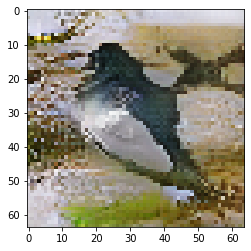

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 22

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.10758972167969 sec
Gen loss: 1.4677490693766897, Gen valid loss: 1.4294854793445204, Gen attr loss: 0.03895880206182087, Disc valid loss: 1.0271755763831822, Disc valid real loss: 0.5247266739203031, Disc valid fake loss: 0.5024489018975234, Disc attr loss: 0.9893451696587289, Disc attr real loss: 0.950386367596908, Disc attr fake loss: 0.03895880206182087
Time for epoch 2 is 34.44141435623169 sec
Gen loss: 1.4568239595831893, Gen valid loss: 1.40979538765057, Gen attr loss: 0.04770956308446117, Disc valid loss: 1.0383703217596865, Disc valid real loss: 0.5298794497480883, Disc valid fake loss: 0.5084908719308331, Disc attr loss: 0.9980408957260265, Disc attr real loss: 0.9503313326415653, Disc attr fake loss: 0.04770956308446117
Time for epoch 3 is 34.217536211013794 sec
Gen loss: 1.4589350309152267, Gen valid loss: 1.419275978393348, Gen attr los

Time for epoch 23 is 34.20339894294739 sec
Gen loss: 1.4782695986714143, Gen valid loss: 1.4419300107128898, Gen attr loss: 0.03704198016308324, Disc valid loss: 1.0221646087279488, Disc valid real loss: 0.5255775151213979, Disc valid fake loss: 0.49658709344502067, Disc attr loss: 0.9833315484141478, Disc attr real loss: 0.9462895682510645, Disc attr fake loss: 0.03704198016308324
Time for epoch 24 is 33.90219688415527 sec
Gen loss: 1.4638664189392958, Gen valid loss: 1.419977556722274, Gen attr loss: 0.04457651415115251, Disc valid loss: 1.0289863008793776, Disc valid real loss: 0.5273457108151299, Disc valid fake loss: 0.5016405905488384, Disc attr loss: 0.9908338835369778, Disc attr real loss: 0.9462573693858253, Disc attr fake loss: 0.04457651415115251
Time for epoch 25 is 34.228853940963745 sec
Gen loss: 1.4545373005595634, Gen valid loss: 1.4155817729670828, Gen attr loss: 0.039643445638714844, Disc valid loss: 1.0311647837724143, Disc valid real loss: 0.529508205529474, Disc va

Time for epoch 45 is 34.07952666282654 sec
Gen loss: 1.468938791978004, Gen valid loss: 1.4340853419730333, Gen attr loss: 0.03555266549983478, Disc valid loss: 1.0246927665501107, Disc valid real loss: 0.5253136346979839, Disc valid fake loss: 0.4993791309637106, Disc attr loss: 0.9756633868198294, Disc attr real loss: 0.9401107213199946, Disc attr fake loss: 0.03555266549983478
Time for epoch 46 is 34.13296175003052 sec
Gen loss: 1.452597356424099, Gen valid loss: 1.4133981149694137, Gen attr loss: 0.039885950379019104, Disc valid loss: 1.0353227761702808, Disc valid real loss: 0.5293588005914921, Disc valid fake loss: 0.5059639767902654, Disc attr loss: 0.9813207237860274, Disc attr real loss: 0.9414347734070083, Disc attr fake loss: 0.039885950379019104
Time for epoch 47 is 34.13171744346619 sec
Gen loss: 1.4684202654898004, Gen valid loss: 1.4267539924722377, Gen attr loss: 0.04235842317057656, Disc valid loss: 1.0217373836331252, Disc valid real loss: 0.5247049283205978, Disc val

Time for epoch 67 is 34.12755846977234 sec
Gen loss: 1.4713429619626301, Gen valid loss: 1.431298401620653, Gen attr loss: 0.04073979224336437, Disc valid loss: 1.0212508283333404, Disc valid real loss: 0.5195084254593061, Disc valid fake loss: 0.50174240343939, Disc attr loss: 0.9769623161788065, Disc attr real loss: 0.936222523935442, Disc attr fake loss: 0.04073979224336437
Time for epoch 68 is 34.14902925491333 sec
Gen loss: 1.4380713862778371, Gen valid loss: 1.400961704370452, Gen attr loss: 0.037791217859103984, Disc valid loss: 1.043838206507003, Disc valid real loss: 0.5384183351586505, Disc valid fake loss: 0.5054198701368761, Disc attr loss: 0.9736741756677976, Disc attr real loss: 0.9358829578086936, Disc attr fake loss: 0.037791217859103984
Time for epoch 69 is 34.11225461959839 sec
Gen loss: 1.4468917987210963, Gen valid loss: 1.4015041676963247, Gen attr loss: 0.04606530311193609, Disc valid loss: 1.0313410870428008, Disc valid real loss: 0.5302095857416065, Disc valid f

Time for epoch 89 is 34.43581795692444 sec
Gen loss: 1.4504146876373911, Gen valid loss: 1.4139199457194425, Gen attr loss: 0.03718306272384749, Disc valid loss: 1.0276731427122907, Disc valid real loss: 0.5284255530614517, Disc valid fake loss: 0.49924758819706716, Disc attr loss: 0.9668003971536582, Disc attr real loss: 0.9296173344298106, Disc attr fake loss: 0.03718306272384749
Time for epoch 90 is 34.30889058113098 sec
Gen loss: 1.439812925449878, Gen valid loss: 1.3984520845619968, Gen attr loss: 0.042039000986013174, Disc valid loss: 1.0429079844376583, Disc valid real loss: 0.5334498374281214, Disc valid fake loss: 0.5094581466057113, Disc attr loss: 0.971034216943417, Disc attr real loss: 0.9289952159574039, Disc attr fake loss: 0.042039000986013174
Time for epoch 91 is 34.29715538024902 sec
Gen loss: 1.4435844456923363, Gen valid loss: 1.4023126544668099, Gen attr loss: 0.04195192457594709, Disc valid loss: 1.0347635629700451, Disc valid real loss: 0.5309065163620119, Disc va

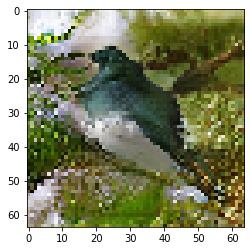

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 23

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.17290377616882 sec
Gen loss: 1.4504852430607245, Gen valid loss: 1.4113382999166886, Gen attr loss: 0.03983264911170869, Disc valid loss: 1.0340180871932487, Disc valid real loss: 0.5299375786529323, Disc valid fake loss: 0.5040805081364909, Disc attr loss: 0.9634501812906703, Disc attr real loss: 0.9236175321789615, Disc attr fake loss: 0.03983264911170869
Time for epoch 2 is 34.35619378089905 sec
Gen loss: 1.4581148440275735, Gen valid loss: 1.4199526736406776, Gen attr loss: 0.03885267123479816, Disc valid loss: 1.0232196878288498, Disc valid real loss: 0.5250234185518611, Disc valid fake loss: 0.49819626911545833, Disc attr loss: 0.9644524632933501, Disc attr real loss: 0.9255997920585518, Disc attr fake loss: 0.03885267123479816
Time for epoch 3 is 34.295045614242554 sec
Gen loss: 1.45196396096289, Gen valid loss: 1.4162584242781973, Gen attr 

Time for epoch 23 is 34.38704824447632 sec
Gen loss: 1.4639441456575057, Gen valid loss: 1.4272018496583148, Gen attr loss: 0.037437127984388745, Disc valid loss: 1.0299406008022587, Disc valid real loss: 0.5264896044563149, Disc valid fake loss: 0.5034509946498767, Disc attr loss: 0.9593413754101477, Disc attr real loss: 0.921904247425759, Disc attr fake loss: 0.037437127984388745
Time for epoch 24 is 34.37919521331787 sec
Gen loss: 1.4515166534640924, Gen valid loss: 1.4128017881052282, Gen attr loss: 0.0394015155530497, Disc valid loss: 1.0311901701821222, Disc valid real loss: 0.5282113058618737, Disc valid fake loss: 0.5029788661778458, Disc attr loss: 0.9614012112966983, Disc attr real loss: 0.9219996957436487, Disc attr fake loss: 0.0394015155530497
Time for epoch 25 is 34.49258065223694 sec
Gen loss: 1.4549264759229128, Gen valid loss: 1.4133137487137544, Gen attr loss: 0.04229818620073328, Disc valid loss: 1.0327940216555505, Disc valid real loss: 0.528336473273714, Disc valid

Time for epoch 45 is 34.46157121658325 sec
Gen loss: 1.452253286108415, Gen valid loss: 1.4155676306747809, Gen attr loss: 0.03737470276786507, Disc valid loss: 1.0266218678091923, Disc valid real loss: 0.5227128580656801, Disc valid fake loss: 0.5039090109549886, Disc attr loss: 0.9560508021671061, Disc attr real loss: 0.918676099399241, Disc attr fake loss: 0.03737470276786507
Time for epoch 46 is 34.27182960510254 sec
Gen loss: 1.4419264289421765, Gen valid loss: 1.4013653415328442, Gen attr loss: 0.04124110541542273, Disc valid loss: 1.0363900814922198, Disc valid real loss: 0.5314559023070141, Disc valid fake loss: 0.5049341788621453, Disc attr loss: 0.9566630417432717, Disc attr real loss: 0.915421936327849, Disc attr fake loss: 0.04124110541542273
Time for epoch 47 is 34.263723373413086 sec
Gen loss: 1.458034275993099, Gen valid loss: 1.41877454632343, Gen attr loss: 0.039949094608662056, Disc valid loss: 1.031012353373737, Disc valid real loss: 0.5282671107509271, Disc valid fa

Time for epoch 67 is 34.364336252212524 sec
Gen loss: 1.4482010801633198, Gen valid loss: 1.4071896510718638, Gen attr loss: 0.041694126982706234, Disc valid loss: 1.0310342747990677, Disc valid real loss: 0.5267785449984274, Disc valid fake loss: 0.5042557305275264, Disc attr loss: 0.9533636733322911, Disc attr real loss: 0.9116695463495849, Disc attr fake loss: 0.041694126982706234
Time for epoch 68 is 34.36272072792053 sec
Gen loss: 1.4626653691940514, Gen valid loss: 1.4309653192354734, Gen attr loss: 0.032399283528116475, Disc valid loss: 1.0227495091071297, Disc valid real loss: 0.5239215866336978, Disc valid fake loss: 0.49882792546174065, Disc attr loss: 0.9429900875712944, Disc attr real loss: 0.9105908040431779, Disc attr fake loss: 0.032399283528116475
Time for epoch 69 is 34.3810248374939 sec
Gen loss: 1.4684883966678526, Gen valid loss: 1.4290997704193198, Gen attr loss: 0.04008308873453817, Disc valid loss: 1.0246559597935456, Disc valid real loss: 0.5241761072702847, Dis

Time for epoch 89 is 34.355846881866455 sec
Gen loss: 1.4492986790209927, Gen valid loss: 1.413171486479803, Gen attr loss: 0.036815319837774724, Disc valid loss: 1.0236408137047517, Disc valid real loss: 0.5236276117605245, Disc valid fake loss: 0.5000132020249922, Disc attr loss: 0.9438761206091779, Disc attr real loss: 0.9070608007714032, Disc attr fake loss: 0.036815319837774724
Time for epoch 90 is 34.378214597702026 sec
Gen loss: 1.473034179307581, Gen valid loss: 1.432152638913493, Gen attr loss: 0.04157678292818307, Disc valid loss: 1.022304239796429, Disc valid real loss: 0.5205677413358921, Disc valid fake loss: 0.5017364987028323, Disc attr loss: 0.9490290573146587, Disc attr real loss: 0.9074522743864757, Disc attr fake loss: 0.04157678292818307
Time for epoch 91 is 34.37556052207947 sec
Gen loss: 1.452072615869, Gen valid loss: 1.4124796183774788, Gen attr loss: 0.04027904912831514, Disc valid loss: 1.0384201814488667, Disc valid real loss: 0.5288918690306708, Disc valid f

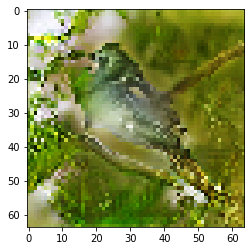

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 24

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.28563642501831 sec
Gen loss: 1.469137437298369, Gen valid loss: 1.4275144438756513, Gen attr loss: 0.042315544596532195, Disc valid loss: 1.0226039067516481, Disc valid real loss: 0.5291180628425061, Disc valid fake loss: 0.4934858466551556, Disc attr loss: 0.9469313506437185, Disc attr real loss: 0.9046158060471863, Disc attr fake loss: 0.042315544596532195
Time for epoch 2 is 34.392311573028564 sec
Gen loss: 1.4642982683207608, Gen valid loss: 1.4246753916184753, Gen attr loss: 0.040315004577023694, Disc valid loss: 1.0226386362298072, Disc valid real loss: 0.5246360845520568, Disc valid fake loss: 0.4980025528892269, Disc attr loss: 0.9450721538724558, Disc attr real loss: 0.9047571492954322, Disc attr fake loss: 0.040315004577023694
Time for epoch 3 is 34.41103458404541 sec
Gen loss: 1.4616237630042925, Gen valid loss: 1.4249377816027096, Gen a

Time for epoch 23 is 34.4363329410553 sec
Gen loss: 1.4462132867435775, Gen valid loss: 1.4160020212493938, Gen attr loss: 0.03090376435856124, Disc valid loss: 1.034514163567768, Disc valid real loss: 0.5316817311413566, Disc valid fake loss: 0.5028324314572301, Disc attr loss: 0.9307573885803164, Disc attr real loss: 0.8998536242217552, Disc attr fake loss: 0.03090376435856124
Time for epoch 24 is 34.41110396385193 sec
Gen loss: 1.4539493320757135, Gen valid loss: 1.4217955239096953, Gen attr loss: 0.03284823183608079, Disc valid loss: 1.026338916968524, Disc valid real loss: 0.5286396855745858, Disc valid fake loss: 0.49769923179776365, Disc attr loss: 0.9330986209177566, Disc attr real loss: 0.9002503890816759, Disc attr fake loss: 0.03284823183608079
Time for epoch 25 is 34.440868616104126 sec
Gen loss: 1.4556291956242506, Gen valid loss: 1.4268217663454816, Gen attr loss: 0.029506037750236244, Disc valid loss: 1.0257870779450993, Disc valid real loss: 0.5271594578496163, Disc val

Time for epoch 45 is 34.40772724151611 sec
Gen loss: 1.4589290570437423, Gen valid loss: 1.4215376994151088, Gen attr loss: 0.038083029972854114, Disc valid loss: 1.0261645242773743, Disc valid real loss: 0.5253678141086082, Disc valid fake loss: 0.5007967093611151, Disc attr loss: 0.9321554248413999, Disc attr real loss: 0.8940723948685457, Disc attr fake loss: 0.038083029972854114
Time for epoch 46 is 34.46254563331604 sec
Gen loss: 1.4570356844886532, Gen valid loss: 1.418849755108841, Gen attr loss: 0.03887586929636035, Disc valid loss: 1.032629334022036, Disc valid real loss: 0.5275762006034695, Disc valid fake loss: 0.5050531335800967, Disc attr loss: 0.9331387431643463, Disc attr real loss: 0.894262873867986, Disc attr fake loss: 0.03887586929636035
Time for epoch 47 is 34.40552568435669 sec
Gen loss: 1.4389568628657479, Gen valid loss: 1.405420929435792, Gen attr loss: 0.03422148200123091, Disc valid loss: 1.0342861798397571, Disc valid real loss: 0.5290430460357407, Disc valid

Time for epoch 67 is 34.46489691734314 sec
Gen loss: 1.4643139018598934, Gen valid loss: 1.4265225802656758, Gen attr loss: 0.03848529043324268, Disc valid loss: 1.026623543200454, Disc valid real loss: 0.5283294837003155, Disc valid fake loss: 0.498294059823199, Disc attr loss: 0.9267542282619838, Disc attr real loss: 0.8882689378287411, Disc attr fake loss: 0.03848529043324268
Time for epoch 68 is 34.415963649749756 sec
Gen loss: 1.4584944535723223, Gen valid loss: 1.417820759905063, Gen attr loss: 0.04136187348996869, Disc valid loss: 1.0295689774722587, Disc valid real loss: 0.5304416043325492, Disc valid fake loss: 0.499127376612609, Disc attr loss: 0.9310154891636748, Disc attr real loss: 0.8896536156737062, Disc attr fake loss: 0.04136187348996869
Time for epoch 69 is 34.43274235725403 sec
Gen loss: 1.4630399832557532, Gen valid loss: 1.4249502811328505, Gen attr loss: 0.038782738452572706, Disc valid loss: 1.0274986513261872, Disc valid real loss: 0.5257871015285088, Disc valid

Time for epoch 89 is 34.438194036483765 sec
Gen loss: 1.4493047725863573, Gen valid loss: 1.4185032069198484, Gen attr loss: 0.03149502382792895, Disc valid loss: 1.0226844923929148, Disc valid real loss: 0.5251141494205651, Disc valid fake loss: 0.49757034224546376, Disc attr loss: 0.9183726550967791, Disc attr real loss: 0.8868776312688502, Disc attr fake loss: 0.03149502382792895
Time for epoch 90 is 34.4395215511322 sec
Gen loss: 1.4543163501796361, Gen valid loss: 1.4229812185938766, Gen attr loss: 0.03203055794712397, Disc valid loss: 1.0286175565021793, Disc valid real loss: 0.5228820998009628, Disc valid fake loss: 0.505735453793673, Disc attr loss: 0.918097044789065, Disc attr real loss: 0.8860664868419409, Disc attr fake loss: 0.03203055794712397
Time for epoch 91 is 34.458932638168335 sec
Gen loss: 1.463579402383427, Gen valid loss: 1.4313264403562882, Gen attr loss: 0.03295209997600192, Disc valid loss: 1.0272150260969228, Disc valid real loss: 0.5246852972320102, Disc vali

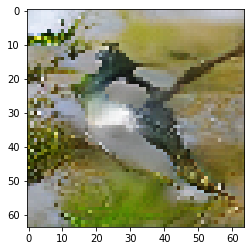

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 25

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.42547941207886 sec
Gen loss: 1.4615410576021768, Gen valid loss: 1.4279891417278507, Gen attr loss: 0.0342487351728817, Disc valid loss: 1.028597523849508, Disc valid real loss: 0.5266851008261445, Disc valid fake loss: 0.5019124222157124, Disc attr loss: 0.9191679501968839, Disc attr real loss: 0.8849192150240022, Disc attr fake loss: 0.0342487351728817
Time for epoch 2 is 34.46021556854248 sec
Gen loss: 1.4473608467313979, Gen valid loss: 1.4153156309593014, Gen attr loss: 0.03273645989993669, Disc valid loss: 1.029923712496512, Disc valid real loss: 0.5266401502013529, Disc valid fake loss: 0.5032835656065282, Disc attr loss: 0.9138279786767863, Disc attr real loss: 0.8810915187768497, Disc attr fake loss: 0.03273645989993669
Time for epoch 3 is 34.436736822128296 sec
Gen loss: 1.442977267875258, Gen valid loss: 1.4101962768611547, Gen attr loss

Time for epoch 23 is 34.54086637496948 sec
Gen loss: 1.4407275188259963, Gen valid loss: 1.4066341333596042, Gen attr loss: 0.034779268762846864, Disc valid loss: 1.038275740334012, Disc valid real loss: 0.5333088301223144, Disc valid fake loss: 0.5049669108578183, Disc attr loss: 0.9128996219508189, Disc attr real loss: 0.878120353187972, Disc attr fake loss: 0.034779268762846864
Time for epoch 24 is 34.508718490600586 sec
Gen loss: 1.4378151144115583, Gen valid loss: 1.4093344185733536, Gen attr loss: 0.029170730294813665, Disc valid loss: 1.0317714522847639, Disc valid real loss: 0.5275845769136579, Disc valid fake loss: 0.5041868748865154, Disc attr loss: 0.9067286354383292, Disc attr real loss: 0.8775579051435155, Disc attr fake loss: 0.029170730294813665
Time for epoch 25 is 34.505043268203735 sec
Gen loss: 1.4665998957021449, Gen valid loss: 1.432305673919719, Gen attr loss: 0.03499282869055999, Disc valid loss: 1.0246251493611633, Disc valid real loss: 0.5215543063513954, Disc 

Time for epoch 45 is 34.522419452667236 sec
Gen loss: 1.4501712632373096, Gen valid loss: 1.4162864633368928, Gen attr loss: 0.03457560557134115, Disc valid loss: 1.0302375559884358, Disc valid real loss: 0.5257137294222669, Disc valid fake loss: 0.5045238260815783, Disc attr loss: 0.9100499565374303, Disc attr real loss: 0.8754743509660892, Disc attr fake loss: 0.03457560557134115
Time for epoch 46 is 34.49548077583313 sec
Gen loss: 1.4435918172846642, Gen valid loss: 1.412470212473779, Gen attr loss: 0.031811886382110084, Disc valid loss: 1.0378061886725387, Disc valid real loss: 0.5325069159350098, Disc valid fake loss: 0.5052992754835424, Disc attr loss: 0.9045842960460471, Disc attr real loss: 0.872772409663937, Disc attr fake loss: 0.031811886382110084
Time for epoch 47 is 34.537270069122314 sec
Gen loss: 1.4537797639686563, Gen valid loss: 1.41759909556164, Gen attr loss: 0.03687098557272236, Disc valid loss: 1.026751952119636, Disc valid real loss: 0.5252885433231912, Disc vali

Time for epoch 67 is 34.49338150024414 sec
Gen loss: 1.4788524826690757, Gen valid loss: 1.4421042808026157, Gen attr loss: 0.03745048358082681, Disc valid loss: 1.0302905983071986, Disc valid real loss: 0.5248205928298516, Disc valid fake loss: 0.5054700083041256, Disc attr loss: 0.9105291045961429, Disc attr real loss: 0.8730786210153161, Disc attr fake loss: 0.03745048358082681
Time for epoch 68 is 34.545886754989624 sec
Gen loss: 1.446217015183715, Gen valid loss: 1.4123992858540397, Gen attr loss: 0.034506625425967, Disc valid loss: 1.03559478317819, Disc valid real loss: 0.5313371688046753, Disc valid fake loss: 0.5042576110621455, Disc attr loss: 0.908045822192456, Disc attr real loss: 0.873539196766489, Disc attr fake loss: 0.034506625425967
Time for epoch 69 is 34.49468994140625 sec
Gen loss: 1.439440898132841, Gen valid loss: 1.4079624362754304, Gen attr loss: 0.03216630609310896, Disc valid loss: 1.0318492681676457, Disc valid real loss: 0.5328376165573513, Disc valid fake l

Time for epoch 89 is 34.727189779281616 sec
Gen loss: 1.4675955933930105, Gen valid loss: 1.4321975078040021, Gen attr loss: 0.03609608512777006, Disc valid loss: 1.0194521111847585, Disc valid real loss: 0.5217548708928633, Disc valid fake loss: 0.4976972422302577, Disc attr loss: 0.9045691313220171, Disc attr real loss: 0.8684730461942471, Disc attr fake loss: 0.03609608512777006
Time for epoch 90 is 34.56100535392761 sec
Gen loss: 1.467787945819741, Gen valid loss: 1.426035028486071, Gen attr loss: 0.04244466469545258, Disc valid loss: 1.0212395735549409, Disc valid real loss: 0.5238361445061237, Disc valid fake loss: 0.4974034300179985, Disc attr loss: 0.9095870350951965, Disc attr real loss: 0.8671423703997438, Disc attr fake loss: 0.04244466469545258
Time for epoch 91 is 34.44732093811035 sec
Gen loss: 1.4462273007808986, Gen valid loss: 1.4160668549498892, Gen attr loss: 0.03085300308739558, Disc valid loss: 1.03970499930343, Disc valid real loss: 0.5323707820761817, Disc valid 

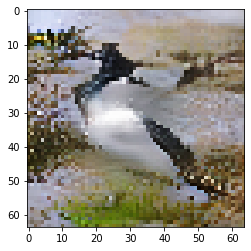

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 26

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.54881715774536 sec
Gen loss: 1.4684904833150103, Gen valid loss: 1.433921302398692, Gen attr loss: 0.03526845643486347, Disc valid loss: 1.0331499650872498, Disc valid real loss: 0.5303159646871614, Disc valid fake loss: 0.5028340006020011, Disc attr loss: 0.9014367034406673, Disc attr real loss: 0.8661682470058037, Disc attr fake loss: 0.03526845643486347
Time for epoch 2 is 34.857272148132324 sec
Gen loss: 1.4259504787321013, Gen valid loss: 1.397138425974342, Gen attr loss: 0.029495825139063334, Disc valid loss: 1.0367981692962853, Disc valid real loss: 0.5328898690741882, Disc valid fake loss: 0.5039082984452649, Disc attr loss: 0.8965970127675225, Disc attr real loss: 0.8671011876284591, Disc attr fake loss: 0.029495825139063334
Time for epoch 3 is 34.64875674247742 sec
Gen loss: 1.4587522160393114, Gen valid loss: 1.4223956758090797, Gen attr

Time for epoch 23 is 34.6307008266449 sec
Gen loss: 1.4457434260748265, Gen valid loss: 1.4132251532743294, Gen attr loss: 0.03320822936334808, Disc valid loss: 1.037491453210836, Disc valid real loss: 0.5295054823725527, Disc valid fake loss: 0.5079859689806858, Disc attr loss: 0.8976058183897759, Disc attr real loss: 0.8643975890264278, Disc attr fake loss: 0.03320822936334808
Time for epoch 24 is 34.61870455741882 sec
Gen loss: 1.4604189265065077, Gen valid loss: 1.4241380775524026, Gen attr loss: 0.03697438093954881, Disc valid loss: 1.026078088658289, Disc valid real loss: 0.5239995298023793, Disc valid fake loss: 0.5020785570790774, Disc attr loss: 0.8983919088684568, Disc attr real loss: 0.861417527928908, Disc attr fake loss: 0.03697438093954881
Time for epoch 25 is 34.474167346954346 sec
Gen loss: 1.4526304163260835, Gen valid loss: 1.4247962561080125, Gen attr loss: 0.028532245574779284, Disc valid loss: 1.0307610290160347, Disc valid real loss: 0.5297331079073392, Disc valid

Time for epoch 45 is 34.57332897186279 sec
Gen loss: 1.4705812462623202, Gen valid loss: 1.4347763471810153, Gen attr loss: 0.03650398822076712, Disc valid loss: 1.025624661426234, Disc valid real loss: 0.5229479635795604, Disc valid fake loss: 0.5026766999465663, Disc attr loss: 0.8957156193198271, Disc attr real loss: 0.85921163109906, Disc attr fake loss: 0.03650398822076712
Time for epoch 46 is 34.5332977771759 sec
Gen loss: 1.4613015700161942, Gen valid loss: 1.4311220978656758, Gen attr loss: 0.03087954144931811, Disc valid loss: 1.025656672674143, Disc valid real loss: 0.5251815878763432, Disc valid fake loss: 0.5004750879476387, Disc attr loss: 0.8893213734729025, Disc attr real loss: 0.8584418320235844, Disc attr fake loss: 0.03087954144931811
Time for epoch 47 is 34.53957986831665 sec
Gen loss: 1.470922705603809, Gen valid loss: 1.4249869888714013, Gen attr loss: 0.04662484718516625, Disc valid loss: 1.020546792968502, Disc valid real loss: 0.5209040778277689, Disc valid fake

Time for epoch 67 is 34.55611777305603 sec
Gen loss: 1.448773670002697, Gen valid loss: 1.4130057862134484, Gen attr loss: 0.03645610800986993, Disc valid loss: 1.0345718180584067, Disc valid real loss: 0.5339791839361837, Disc valid fake loss: 0.5005926346068137, Disc attr loss: 0.8889654907889061, Disc attr real loss: 0.8525093827790361, Disc attr fake loss: 0.03645610800986993
Time for epoch 68 is 34.54590940475464 sec
Gen loss: 1.4556683137164852, Gen valid loss: 1.4187253871907386, Gen attr loss: 0.037633426179514304, Disc valid loss: 1.0308807616634421, Disc valid real loss: 0.5258489870605106, Disc valid fake loss: 0.5050317749259917, Disc attr loss: 0.8912608184495688, Disc attr real loss: 0.8536273922700546, Disc attr fake loss: 0.037633426179514304
Time for epoch 69 is 34.58138132095337 sec
Gen loss: 1.4443974378632336, Gen valid loss: 1.4079025305383575, Gen attr loss: 0.037180222294672216, Disc valid loss: 1.0377250673971201, Disc valid real loss: 0.527989081331708, Disc va

Time for epoch 89 is 34.54382872581482 sec
Gen loss: 1.4381929642462794, Gen valid loss: 1.4119935801358727, Gen attr loss: 0.02689188659319893, Disc valid loss: 1.0289250445882803, Disc valid real loss: 0.5259319046325477, Disc valid fake loss: 0.5029931400364976, Disc attr loss: 0.8785975719722583, Disc attr real loss: 0.8517056853790593, Disc attr fake loss: 0.02689188659319893
Time for epoch 90 is 34.57137680053711 sec
Gen loss: 1.447165956019063, Gen valid loss: 1.4138520264690162, Gen attr loss: 0.03400380517096956, Disc valid loss: 1.030745491102782, Disc valid real loss: 0.5254066498460486, Disc valid fake loss: 0.5053388410952033, Disc attr loss: 0.8867582849145704, Disc attr real loss: 0.8527544797436009, Disc attr fake loss: 0.03400380517096956
Time for epoch 91 is 34.512133836746216 sec
Gen loss: 1.4470914847805572, Gen valid loss: 1.4159861129473865, Gen attr loss: 0.031797421286830246, Disc valid loss: 1.039504069461409, Disc valid real loss: 0.5306579458519696, Disc vali

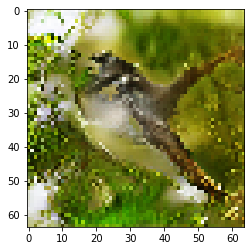

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 27

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.43567943572998 sec
Gen loss: 1.4491661166757104, Gen valid loss: 1.4182320574757852, Gen attr loss: 0.031627313063104776, Disc valid loss: 1.035399375892267, Disc valid real loss: 0.530325513868151, Disc valid fake loss: 0.5050738596819281, Disc attr loss: 0.8795687900258585, Disc attr real loss: 0.8479414769627538, Disc attr fake loss: 0.031627313063104776
Time for epoch 2 is 34.70419359207153 sec
Gen loss: 1.4484537258380796, Gen valid loss: 1.4162773226657857, Gen attr loss: 0.03286805546649559, Disc valid loss: 1.029581855144604, Disc valid real loss: 0.5285977848823155, Disc valid fake loss: 0.5009840708276444, Disc attr loss: 0.8800849500188092, Disc attr real loss: 0.8472168945523135, Disc attr fake loss: 0.03286805546649559
Time for epoch 3 is 34.65806603431702 sec
Gen loss: 1.4470903689299173, Gen valid loss: 1.4134026930584171, Gen attr l

Time for epoch 23 is 34.626842737197876 sec
Gen loss: 1.453988226125557, Gen valid loss: 1.416823405398909, Gen attr loss: 0.03785425298384093, Disc valid loss: 1.0355589582021967, Disc valid real loss: 0.5307452194897463, Disc valid fake loss: 0.5048137374202087, Disc attr loss: 0.8865305885450842, Disc attr real loss: 0.8486763355612432, Disc attr fake loss: 0.03785425298384093
Time for epoch 24 is 34.67380356788635 sec
Gen loss: 1.436457623634235, Gen valid loss: 1.405656178146197, Gen attr loss: 0.03148848020084725, Disc valid loss: 1.036165395403296, Disc valid real loss: 0.5317021249755611, Disc valid fake loss: 0.5044632734160436, Disc attr loss: 0.8771777174801447, Disc attr real loss: 0.8456892372792976, Disc attr fake loss: 0.03148848020084725
Time for epoch 25 is 34.60511350631714 sec
Gen loss: 1.4701124258480744, Gen valid loss: 1.4319302144089365, Gen attr loss: 0.03887868771750989, Disc valid loss: 1.0197804064608524, Disc valid real loss: 0.5181097491646847, Disc valid f

Time for epoch 45 is 34.64767861366272 sec
Gen loss: 1.4558103103947833, Gen valid loss: 1.4225713634878638, Gen attr loss: 0.03393321798455335, Disc valid loss: 1.0293156440018962, Disc valid real loss: 0.5252324293460949, Disc valid fake loss: 0.5040832136058548, Disc attr loss: 0.87392697050352, Disc attr real loss: 0.8399937525189666, Disc attr fake loss: 0.03393321798455335
Time for epoch 46 is 34.5955548286438 sec
Gen loss: 1.460211729292624, Gen valid loss: 1.432316717093553, Gen attr loss: 0.02859682053827217, Disc valid loss: 1.0271246612556582, Disc valid real loss: 0.5254348941288667, Disc valid fake loss: 0.5016897680152076, Disc attr loss: 0.8708428937480915, Disc attr real loss: 0.8422460732098195, Disc attr fake loss: 0.02859682053827217
Time for epoch 47 is 34.580649614334106 sec
Gen loss: 1.4534887014042717, Gen valid loss: 1.4203851733427384, Gen attr loss: 0.033796774897023985, Disc valid loss: 1.0314094601930965, Disc valid real loss: 0.5265295118658846, Disc valid 

Time for epoch 67 is 34.58022880554199 sec
Gen loss: 1.4691248702486033, Gen valid loss: 1.434228996274271, Gen attr loss: 0.03559514386733085, Disc valid loss: 1.0240246257807828, Disc valid real loss: 0.5210648959245139, Disc valid fake loss: 0.5029597279179064, Disc attr loss: 0.876871342169835, Disc attr real loss: 0.8412761983025042, Disc attr fake loss: 0.03559514386733085
Time for epoch 68 is 34.578007221221924 sec
Gen loss: 1.4574396348581082, Gen valid loss: 1.419434346157684, Gen attr loss: 0.03869560739277324, Disc valid loss: 1.032192760043674, Disc valid real loss: 0.5290060825948792, Disc valid fake loss: 0.5031866755104324, Disc attr loss: 0.8756385286364823, Disc attr real loss: 0.836942921243709, Disc attr fake loss: 0.03869560739277324
Time for epoch 69 is 34.57839512825012 sec
Gen loss: 1.4741727895529935, Gen valid loss: 1.441357460125352, Gen attr loss: 0.033519198952469534, Disc valid loss: 1.0255672359854224, Disc valid real loss: 0.5260575731110767, Disc valid f

Time for epoch 89 is 34.57483267784119 sec
Gen loss: 1.456155017139466, Gen valid loss: 1.4227097147525487, Gen attr loss: 0.03413953432510133, Disc valid loss: 1.028912765708396, Disc valid real loss: 0.5255472803018927, Disc valid fake loss: 0.5033654817720739, Disc attr loss: 0.8707935513709933, Disc attr real loss: 0.836654017045892, Disc attr fake loss: 0.03413953432510133
Time for epoch 90 is 34.560734033584595 sec
Gen loss: 1.4608480742953334, Gen valid loss: 1.4301220553354197, Gen attr loss: 0.0314253155154612, Disc valid loss: 1.023199683605494, Disc valid real loss: 0.522923741318023, Disc valid fake loss: 0.5002759447911891, Disc attr loss: 0.8655943940025059, Disc attr real loss: 0.8341690784870448, Disc attr fake loss: 0.0314253155154612
Time for epoch 91 is 34.57989835739136 sec
Gen loss: 1.4519476993943294, Gen valid loss: 1.4130804070289218, Gen attr loss: 0.03955400656191581, Disc valid loss: 1.0362553685338194, Disc valid real loss: 0.5287162688204913, Disc valid fak

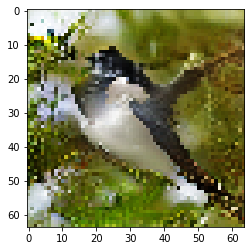

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 28

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.57342004776001 sec
Gen loss: 1.4491986197830862, Gen valid loss: 1.4097448157747263, Gen attr loss: 0.040138559154421674, Disc valid loss: 1.041726746371768, Disc valid real loss: 0.5371235034814695, Disc valid fake loss: 0.50460324006352, Disc attr loss: 0.8719777617774788, Disc attr real loss: 0.8318392026230572, Disc attr fake loss: 0.040138559154421674
Time for epoch 2 is 34.560826778411865 sec
Gen loss: 1.438548676043668, Gen valid loss: 1.4074902578098019, Gen attr loss: 0.0317462443871125, Disc valid loss: 1.0354349674571175, Disc valid real loss: 0.5277281166899818, Disc valid fake loss: 0.5077068504440753, Disc attr loss: 0.865701724379873, Disc attr real loss: 0.8339554799927605, Disc attr fake loss: 0.0317462443871125
Time for epoch 3 is 34.49321699142456 sec
Gen loss: 1.4696565398032748, Gen valid loss: 1.438583079392348, Gen attr loss:

Time for epoch 23 is 34.457088470458984 sec
Gen loss: 1.4749238872269628, Gen valid loss: 1.4377623486325024, Gen attr loss: 0.037861438952671925, Disc valid loss: 1.029200622544379, Disc valid real loss: 0.5278049196977279, Disc valid fake loss: 0.5013957046234834, Disc attr loss: 0.8645228998821187, Disc attr real loss: 0.8266614609294467, Disc attr fake loss: 0.037861438952671925
Time for epoch 24 is 34.48020148277283 sec
Gen loss: 1.4632604209388174, Gen valid loss: 1.4225959806907467, Gen attr loss: 0.0413550143662424, Disc valid loss: 1.028422190244928, Disc valid real loss: 0.5295511497068535, Disc valid fake loss: 0.4988710380343564, Disc attr loss: 0.8708592537315798, Disc attr real loss: 0.8295042393653373, Disc attr fake loss: 0.0413550143662424
Time for epoch 25 is 34.54514265060425 sec
Gen loss: 1.4439424799709786, Gen valid loss: 1.410351293035316, Gen attr loss: 0.03427917000378234, Disc valid loss: 1.036790509534076, Disc valid real loss: 0.5331725121998205, Disc valid 

Time for epoch 45 is 34.46764636039734 sec
Gen loss: 1.457951800933052, Gen valid loss: 1.431079575685951, Gen attr loss: 0.027573932006896215, Disc valid loss: 1.0285570225741483, Disc valid real loss: 0.5262662027747973, Disc valid fake loss: 0.5022908192339951, Disc attr loss: 0.852166473314511, Disc attr real loss: 0.8245925413076147, Disc attr fake loss: 0.027573932006896215
Time for epoch 46 is 34.50481700897217 sec
Gen loss: 1.446358441014277, Gen valid loss: 1.4141158414726982, Gen attr loss: 0.03293314198284062, Disc valid loss: 1.0341393543775812, Disc valid real loss: 0.5278541851980576, Disc valid fake loss: 0.506285170310235, Disc attr loss: 0.8612407268397476, Disc attr real loss: 0.8283075848569069, Disc attr fake loss: 0.03293314198284062
Time for epoch 47 is 34.453752517700195 sec
Gen loss: 1.4509058260336154, Gen valid loss: 1.4187040981561512, Gen attr loss: 0.03289458343248765, Disc valid loss: 1.0280956289955594, Disc valid real loss: 0.5256019825050178, Disc valid

Time for epoch 67 is 34.518038511276245 sec
Gen loss: 1.4605473422099582, Gen valid loss: 1.4278138170074317, Gen attr loss: 0.033430665813994384, Disc valid loss: 1.0261733103896866, Disc valid real loss: 0.5244866961709206, Disc valid fake loss: 0.5016866152687125, Disc attr loss: 0.8546796650681616, Disc attr real loss: 0.8212489992541673, Disc attr fake loss: 0.033430665813994384
Time for epoch 68 is 34.20344114303589 sec
Gen loss: 1.457119226132628, Gen valid loss: 1.4242499385099747, Gen attr loss: 0.03356457950560041, Disc valid loss: 1.0335202386708764, Disc valid real loss: 0.5279586567949797, Disc valid fake loss: 0.5055615801798296, Disc attr loss: 0.856176073540856, Disc attr real loss: 0.8226114940352556, Disc attr fake loss: 0.03356457950560041
Time for epoch 69 is 34.41568374633789 sec
Gen loss: 1.477246092910043, Gen valid loss: 1.444848852752024, Gen attr loss: 0.033103063952099644, Disc valid loss: 1.0189172027879938, Disc valid real loss: 0.5230612371187546, Disc val

Time for epoch 89 is 34.36485457420349 sec
Gen loss: 1.4511552173593827, Gen valid loss: 1.4174518656278368, Gen attr loss: 0.03439482874999564, Disc valid loss: 1.030184842060575, Disc valid real loss: 0.5264515339682095, Disc valid fake loss: 0.5037333073654795, Disc attr loss: 0.8555734337879717, Disc attr real loss: 0.8211786050379761, Disc attr fake loss: 0.03439482874999564
Time for epoch 90 is 34.379836082458496 sec
Gen loss: 1.4768719543932576, Gen valid loss: 1.4472122783583354, Gen attr loss: 0.030368047759167394, Disc valid loss: 1.0228764240334673, Disc valid real loss: 0.5234299486245566, Disc valid fake loss: 0.4994464753281456, Disc attr loss: 0.8491995375011312, Disc attr real loss: 0.8188314897419637, Disc attr fake loss: 0.030368047759167394
Time for epoch 91 is 34.40968155860901 sec
Gen loss: 1.449842390975332, Gen valid loss: 1.415625086967861, Gen attr loss: 0.03490761146495923, Disc valid loss: 1.0320295865942792, Disc valid real loss: 0.529840614737534, Disc vali

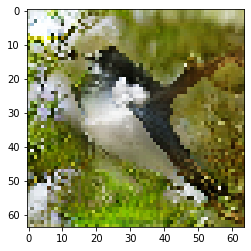

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 29

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.386231899261475 sec
Gen loss: 1.4607937474883992, Gen valid loss: 1.427653522672369, Gen attr loss: 0.03383708378825309, Disc valid loss: 1.0318869735167278, Disc valid real loss: 0.5267940377639885, Disc valid fake loss: 0.5050929355104441, Disc attr loss: 0.8558912289241069, Disc attr real loss: 0.8220541451358536, Disc attr fake loss: 0.03383708378825309
Time for epoch 2 is 34.34967303276062 sec
Gen loss: 1.4566082880102844, Gen valid loss: 1.4213193251188532, Gen attr loss: 0.035981581853778935, Disc valid loss: 1.0293045325007866, Disc valid real loss: 0.5244824202241614, Disc valid fake loss: 0.5048221142149876, Disc attr loss: 0.8556858935845179, Disc attr real loss: 0.8197043117307389, Disc attr fake loss: 0.035981581853778935
Time for epoch 3 is 34.34875535964966 sec
Gen loss: 1.4366422888386217, Gen valid loss: 1.4076429728246962, Gen att

Time for epoch 23 is 34.3904550075531 sec
Gen loss: 1.4506736189369265, Gen valid loss: 1.425393666032207, Gen attr loss: 0.025979613797494937, Disc valid loss: 1.0314374472390668, Disc valid real loss: 0.5316503002714659, Disc valid fake loss: 0.49978714817907754, Disc attr loss: 0.8411976519074009, Disc attr real loss: 0.815218038109906, Disc attr fake loss: 0.025979613797494937
Time for epoch 24 is 34.397544145584106 sec
Gen loss: 1.449423222037835, Gen valid loss: 1.4144183998185444, Gen attr loss: 0.03569413658430156, Disc valid loss: 1.0288553546437726, Disc valid real loss: 0.5256305708471676, Disc valid fake loss: 0.5032247828274239, Disc attr loss: 0.852011045804139, Disc attr real loss: 0.8163169092198375, Disc attr fake loss: 0.03569413658430156
Time for epoch 25 is 34.407907247543335 sec
Gen loss: 1.4509265933256486, Gen valid loss: 1.4170208051598816, Gen attr loss: 0.034596951146596375, Disc valid loss: 1.0294281651334065, Disc valid real loss: 0.5266706546147665, Disc va

Time for epoch 45 is 34.338786363601685 sec
Gen loss: 1.4510806815087958, Gen valid loss: 1.417244240197386, Gen attr loss: 0.03452775025132961, Disc valid loss: 1.031646377833555, Disc valid real loss: 0.5294777605591751, Disc valid fake loss: 0.5021686142053061, Disc attr loss: 0.8480535105301219, Disc attr real loss: 0.8135257602787922, Disc attr fake loss: 0.03452775025132961
Time for epoch 46 is 34.34174585342407 sec
Gen loss: 1.4642173775489413, Gen valid loss: 1.4323668835285879, Gen attr loss: 0.03255035151328768, Disc valid loss: 1.0264928673664082, Disc valid real loss: 0.5253638948205364, Disc valid fake loss: 0.5011289729496974, Disc attr loss: 0.8473980841777345, Disc attr real loss: 0.8148477326644469, Disc attr fake loss: 0.03255035151328768
Time for epoch 47 is 34.352243185043335 sec
Gen loss: 1.4481948643195919, Gen valid loss: 1.4247133382936803, Gen attr loss: 0.024181742999346428, Disc valid loss: 1.0307547261075276, Disc valid real loss: 0.5264037772407376, Disc va

Time for epoch 67 is 34.592498779296875 sec
Gen loss: 1.4602514792910113, Gen valid loss: 1.427353084248902, Gen attr loss: 0.033595225990432555, Disc valid loss: 1.0238061631275064, Disc valid real loss: 0.5257841218616258, Disc valid fake loss: 0.49802204199276645, Disc attr loss: 0.8436125059681535, Disc attr real loss: 0.8100172799777209, Disc attr fake loss: 0.033595225990432555
Time for epoch 68 is 34.755069971084595 sec
Gen loss: 1.453945236800486, Gen valid loss: 1.4257131653426462, Gen attr loss: 0.02893041248184724, Disc valid loss: 1.0358202791795499, Disc valid real loss: 0.5316008492536984, Disc valid fake loss: 0.5042194307335024, Disc attr loss: 0.8389070172969453, Disc attr real loss: 0.809976604815098, Disc attr fake loss: 0.02893041248184724
Time for epoch 69 is 34.66630816459656 sec
Gen loss: 1.4476288056308984, Gen valid loss: 1.4175358711865536, Gen attr loss: 0.030786261329685885, Disc valid loss: 1.0327001937682712, Disc valid real loss: 0.5236435586682503, Disc 

Time for epoch 89 is 34.37508702278137 sec
Gen loss: 1.4603278268643511, Gen valid loss: 1.4276333914862738, Gen attr loss: 0.033391507240468944, Disc valid loss: 1.0276839857502036, Disc valid real loss: 0.5231118651263436, Disc valid fake loss: 0.5045721203815646, Disc attr loss: 0.8422832043432379, Disc attr real loss: 0.808891697102769, Disc attr fake loss: 0.033391507240468944
Time for epoch 90 is 34.356146812438965 sec
Gen loss: 1.4703188637084754, Gen valid loss: 1.4324832305029478, Gen attr loss: 0.038532561611033016, Disc valid loss: 1.023696593798919, Disc valid real loss: 0.5240025311950746, Disc valid fake loss: 0.4996940595347707, Disc attr loss: 0.8447854697846483, Disc attr real loss: 0.8062529081736154, Disc attr fake loss: 0.038532561611033016
Time for epoch 91 is 34.36910390853882 sec
Gen loss: 1.460213448620101, Gen valid loss: 1.4305229736214409, Gen attr loss: 0.030390491083154843, Disc valid loss: 1.0309320476643116, Disc valid real loss: 0.5288652604026847, Disc 

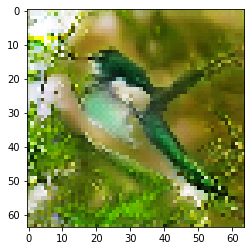

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 30

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 34.38107204437256 sec
Gen loss: 1.4488356883932905, Gen valid loss: 1.4188470929295713, Gen attr loss: 0.030682629561499603, Disc valid loss: 1.028816711450334, Disc valid real loss: 0.5277241632382721, Disc valid fake loss: 0.5010925495043034, Disc attr loss: 0.8382934598384618, Disc attr real loss: 0.8076108302769622, Disc attr fake loss: 0.030682629561499603
Time for epoch 2 is 34.40604329109192 sec
Gen loss: 1.4537182545597314, Gen valid loss: 1.4242237547871865, Gen attr loss: 0.030191464969399145, Disc valid loss: 1.023400971398444, Disc valid real loss: 0.5235824520348856, Disc valid fake loss: 0.4998185192020282, Disc attr loss: 0.837802484277081, Disc attr real loss: 0.8076110193076819, Disc attr fake loss: 0.030191464969399145
Time for epoch 3 is 34.41298246383667 sec
Gen loss: 1.4635532008923167, Gen valid loss: 1.4370986759501099, Gen attr

Time for epoch 23 is 34.030362606048584 sec
Gen loss: 1.433915852531185, Gen valid loss: 1.4002978414054807, Gen attr loss: 0.034300958047970176, Disc valid loss: 1.0403954440016088, Disc valid real loss: 0.5315702517988882, Disc valid fake loss: 0.5088251901028279, Disc attr loss: 0.8393334559104604, Disc attr real loss: 0.8050324978624902, Disc attr fake loss: 0.034300958047970176
Time for epoch 24 is 34.031986236572266 sec
Gen loss: 1.447280685753034, Gen valid loss: 1.4033020734786987, Gen attr loss: 0.044657887559055115, Disc valid loss: 1.0392375614261886, Disc valid real loss: 0.5302664870169105, Disc valid fake loss: 0.5089710745708083, Disc attr loss: 0.8454499904503103, Disc attr real loss: 0.8007921028912552, Disc attr fake loss: 0.044657887559055115
Time for epoch 25 is 34.01385736465454 sec
Gen loss: 1.4520992437998455, Gen valid loss: 1.4164936994795554, Gen attr loss: 0.03629559166328758, Disc valid loss: 1.0300340138799775, Disc valid real loss: 0.5282317070457024, Disc

Time for epoch 45 is 34.07678818702698 sec
Gen loss: 1.450070115931958, Gen valid loss: 1.4224266476101346, Gen attr loss: 0.02834046188725622, Disc valid loss: 1.0355296721303366, Disc valid real loss: 0.530894616351218, Disc valid fake loss: 0.5046350556175884, Disc attr loss: 0.828589863054251, Disc attr real loss: 0.8002494011669947, Disc attr fake loss: 0.02834046188725622
Time for epoch 46 is 33.74138951301575 sec
Gen loss: 1.4551904476108912, Gen valid loss: 1.4204389076568893, Gen attr loss: 0.035443988459298616, Disc valid loss: 1.0315421050803124, Disc valid real loss: 0.526279882525364, Disc valid fake loss: 0.5052622255432574, Disc attr loss: 0.8357173768815771, Disc attr real loss: 0.8002733884222786, Disc attr fake loss: 0.035443988459298616
Time for epoch 47 is 34.05111813545227 sec
Gen loss: 1.4440115641772262, Gen valid loss: 1.408689151288371, Gen attr loss: 0.03600870389768992, Disc valid loss: 1.0381253592690156, Disc valid real loss: 0.530112341248246, Disc valid f

Time for epoch 67 is 33.90572762489319 sec
Gen loss: 1.44923527421667, Gen valid loss: 1.414321689424799, Gen attr loss: 0.03560290030511781, Disc valid loss: 1.0317485380948075, Disc valid real loss: 0.5262576147792785, Disc valid fake loss: 0.505490926546133, Disc attr loss: 0.8291088529961159, Disc attr real loss: 0.7935059526909981, Disc attr fake loss: 0.03560290030511781
Time for epoch 68 is 33.8783004283905 sec
Gen loss: 1.4735603917258864, Gen valid loss: 1.4399517674433184, Gen attr loss: 0.03431139290399977, Disc valid loss: 1.0216654508417538, Disc valid real loss: 0.5186480794172623, Disc valid fake loss: 0.5030173711821961, Disc attr loss: 0.829088544959324, Disc attr real loss: 0.7947771520553243, Disc attr fake loss: 0.03431139290399977
Time for epoch 69 is 33.93109464645386 sec
Gen loss: 1.4612277982034658, Gen valid loss: 1.4351765893016082, Gen attr loss: 0.026755367094422798, Disc valid loss: 1.0268409958053735, Disc valid real loss: 0.5243974391037856, Disc valid fa

Time for epoch 89 is 33.96619486808777 sec
Gen loss: 1.444826406838125, Gen valid loss: 1.4175227037290248, Gen attr loss: 0.02799841463818895, Disc valid loss: 1.0321577399726805, Disc valid real loss: 0.532559526483541, Disc valid fake loss: 0.49959821389296516, Disc attr loss: 0.8205831312253978, Disc attr real loss: 0.7925847165872087, Disc attr fake loss: 0.02799841463818895
Time for epoch 90 is 33.96885132789612 sec
Gen loss: 1.421530716141388, Gen valid loss: 1.39188369373642, Gen attr loss: 0.030327754070677695, Disc valid loss: 1.042308716593073, Disc valid real loss: 0.5330492299262101, Disc valid fake loss: 0.5092594855361514, Disc attr loss: 0.8225337042604128, Disc attr real loss: 0.7922059501897352, Disc attr fake loss: 0.030327754070677695
Time for epoch 91 is 34.00231623649597 sec
Gen loss: 1.4484750361946541, Gen valid loss: 1.4172541759201505, Gen attr loss: 0.03191348383119224, Disc valid loss: 1.036682167188908, Disc valid real loss: 0.5271392587400711, Disc valid f

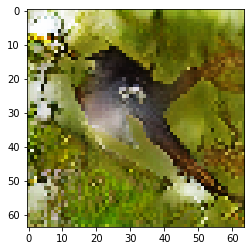

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 31

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 33.9717800617218 sec
Gen loss: 1.4471051899721306, Gen valid loss: 1.4109163991804046, Gen attr loss: 0.036875762271356693, Disc valid loss: 1.0440082768114602, Disc valid real loss: 0.5333603842633203, Disc valid fake loss: 0.510647891094368, Disc attr loss: 0.8269911448441795, Disc attr real loss: 0.7901153825728228, Disc attr fake loss: 0.036875762271356693
Time for epoch 2 is 34.02235412597656 sec
Gen loss: 1.4494321973020146, Gen valid loss: 1.4196424225804605, Gen attr loss: 0.030484306763965414, Disc valid loss: 1.0302414354593128, Disc valid real loss: 0.5262980510387317, Disc valid fake loss: 0.5039433819976279, Disc attr loss: 0.8199931283631711, Disc attr real loss: 0.7895088215992057, Disc attr fake loss: 0.030484306763965414
Time for epoch 3 is 33.99734306335449 sec
Gen loss: 1.4523917443060939, Gen valid loss: 1.421260135283638, Gen attr

Time for epoch 23 is 33.918415546417236 sec
Gen loss: 1.4391177085033924, Gen valid loss: 1.4073151201413576, Gen attr loss: 0.032489948683299914, Disc valid loss: 1.039082427011919, Disc valid real loss: 0.5330414545083757, Disc valid fake loss: 0.5060409718574224, Disc attr loss: 0.8209445089686381, Disc attr real loss: 0.7884545602853382, Disc attr fake loss: 0.032489948683299914
Time for epoch 24 is 33.93709874153137 sec
Gen loss: 1.4581199645349974, Gen valid loss: 1.4304889679601198, Gen attr loss: 0.028332027211726687, Disc valid loss: 1.024807618562445, Disc valid real loss: 0.5228452870677803, Disc valid fake loss: 0.5019623327869064, Disc attr loss: 0.8197847639645158, Disc attr real loss: 0.7914527367527892, Disc attr fake loss: 0.028332027211726687
Time for epoch 25 is 33.93365693092346 sec
Gen loss: 1.4397569421507155, Gen valid loss: 1.4111919876359666, Gen attr loss: 0.029255872471860785, Disc valid loss: 1.0361389290026533, Disc valid real loss: 0.5290775265958574, Disc

Time for epoch 45 is 33.94890093803406 sec
Gen loss: 1.444459261609933, Gen valid loss: 1.4108893897152206, Gen attr loss: 0.0342581399328102, Disc valid loss: 1.0339202499648097, Disc valid real loss: 0.5247518279688145, Disc valid fake loss: 0.5091684223190556, Disc attr loss: 0.8216748612761582, Disc attr real loss: 0.7874167213433481, Disc attr fake loss: 0.0342581399328102
Time for epoch 46 is 33.93100452423096 sec
Gen loss: 1.4568209728897425, Gen valid loss: 1.4310605580890727, Gen attr loss: 0.026462664411978892, Disc valid loss: 1.0298825221333077, Disc valid real loss: 0.5266324111278141, Disc valid fake loss: 0.5032501141553326, Disc attr loss: 0.814360386637181, Disc attr real loss: 0.7878977222252022, Disc attr fake loss: 0.026462664411978892
Time for epoch 47 is 34.00212121009827 sec
Gen loss: 1.43284675680848, Gen valid loss: 1.399524456763332, Gen attr loss: 0.0340050126018875, Disc valid loss: 1.0381886834697671, Disc valid real loss: 0.5344710733670852, Disc valid fak

Time for epoch 67 is 33.94209027290344 sec
Gen loss: 1.4471203747803603, Gen valid loss: 1.417338966354122, Gen attr loss: 0.030474790738607944, Disc valid loss: 1.0385975046209526, Disc valid real loss: 0.5312891004046774, Disc valid fake loss: 0.5073084067199934, Disc attr loss: 0.8145010812028153, Disc attr real loss: 0.7840262904642074, Disc attr fake loss: 0.030474790738607944
Time for epoch 68 is 33.99619674682617 sec
Gen loss: 1.4451357623748986, Gen valid loss: 1.4107625846294207, Gen attr loss: 0.03506097693257489, Disc valid loss: 1.0364027129925364, Disc valid real loss: 0.5297185262528862, Disc valid fake loss: 0.5066841864165897, Disc attr loss: 0.819686032276699, Disc attr real loss: 0.7846250553441242, Disc attr fake loss: 0.03506097693257489
Time for epoch 69 is 33.95031380653381 sec
Gen loss: 1.4431087731668943, Gen valid loss: 1.409601577898351, Gen attr loss: 0.03419485335886008, Disc valid loss: 1.0380994338330214, Disc valid real loss: 0.5323529151397023, Disc vali

Time for epoch 89 is 33.946157932281494 sec
Gen loss: 1.4409968197184204, Gen valid loss: 1.4155064270425295, Gen attr loss: 0.026185006227685582, Disc valid loss: 1.0303969336395988, Disc valid real loss: 0.52516809025108, Disc valid fake loss: 0.5052288432269885, Disc attr loss: 0.8076566500567729, Disc attr real loss: 0.7814716438290873, Disc attr fake loss: 0.026185006227685582
Time for epoch 90 is 33.98196005821228 sec
Gen loss: 1.479317321040766, Gen valid loss: 1.447499717154154, Gen attr loss: 0.032525043467625976, Disc valid loss: 1.0189499619207407, Disc valid real loss: 0.5173686876045009, Disc valid fake loss: 0.5015812738316492, Disc attr loss: 0.8150169837760185, Disc attr real loss: 0.7824919403083925, Disc attr fake loss: 0.032525043467625976
Time for epoch 91 is 33.94313335418701 sec
Gen loss: 1.4582642038986289, Gen valid loss: 1.4209837147860023, Gen attr loss: 0.03797194642647859, Disc valid loss: 1.0386475352090871, Disc valid real loss: 0.531819019537308, Disc val

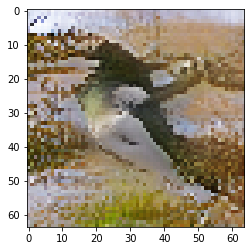

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 32

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 33.94851994514465 sec
Gen loss: 1.4706106344212684, Gen valid loss: 1.439022717437124, Gen attr loss: 0.03229122956318825, Disc valid loss: 1.0286186237322283, Disc valid real loss: 0.5243668468987069, Disc valid fake loss: 0.5042517753797495, Disc attr loss: 0.8155427382701417, Disc attr real loss: 0.7832515087069535, Disc attr fake loss: 0.03229122956318825
Time for epoch 2 is 33.94162201881409 sec
Gen loss: 1.4479871468169256, Gen valid loss: 1.4140689156565887, Gen attr loss: 0.034607915334119235, Disc valid loss: 1.038456909540223, Disc valid real loss: 0.5303281590867495, Disc valid fake loss: 0.5081287494842922, Disc attr loss: 0.8162778004965348, Disc attr real loss: 0.7816698851624155, Disc attr fake loss: 0.034607915334119235
Time for epoch 3 is 33.960912466049194 sec
Gen loss: 1.4495968644211932, Gen valid loss: 1.419121654537635, Gen attr 

Time for epoch 23 is 34.0369656085968 sec
Gen loss: 1.4571380821993034, Gen valid loss: 1.4299241608074365, Gen attr loss: 0.027914873974128188, Disc valid loss: 1.0306765758571264, Disc valid real loss: 0.525421352971214, Disc valid fake loss: 0.5052552230474425, Disc attr loss: 0.8061220933641703, Disc attr real loss: 0.7782072193900421, Disc attr fake loss: 0.027914873974128188
Time for epoch 24 is 34.030611515045166 sec
Gen loss: 1.469640541852005, Gen valid loss: 1.4349349136275005, Gen attr loss: 0.035405347797412716, Disc valid loss: 1.028538239034534, Disc valid real loss: 0.5261078575439246, Disc valid fake loss: 0.502430378906126, Disc attr loss: 0.8155606824089849, Disc attr real loss: 0.7801553346115723, Disc attr fake loss: 0.035405347797412716
Time for epoch 25 is 34.055625677108765 sec
Gen loss: 1.4549087344146356, Gen valid loss: 1.4240418520723255, Gen attr loss: 0.031563076556396015, Disc valid loss: 1.0268497727104642, Disc valid real loss: 0.5236195132822848, Disc v

Time for epoch 45 is 34.01538276672363 sec
Gen loss: 1.46366256782356, Gen valid loss: 1.429005911841302, Gen attr loss: 0.035353431632648626, Disc valid loss: 1.0269160189925817, Disc valid real loss: 0.5250099696279541, Disc valid fake loss: 0.5019060512222249, Disc attr loss: 0.812578038207038, Disc attr real loss: 0.7772246065743893, Disc attr fake loss: 0.035353431632648626
Time for epoch 46 is 33.979682207107544 sec
Gen loss: 1.457963120646593, Gen valid loss: 1.4262578739383356, Gen attr loss: 0.03240212193567032, Disc valid loss: 1.0348835892793609, Disc valid real loss: 0.5310907371968112, Disc valid fake loss: 0.5037928526479054, Disc attr loss: 0.8092074149626487, Disc attr real loss: 0.7768052930269784, Disc attr fake loss: 0.03240212193567032
Time for epoch 47 is 34.25122618675232 sec
Gen loss: 1.4744635306722749, Gen valid loss: 1.4444506636803067, Gen attr loss: 0.03071968213003162, Disc valid loss: 1.0304721435557214, Disc valid real loss: 0.5278690940319362, Disc valid

Time for epoch 67 is 33.92836260795593 sec
Gen loss: 1.4630086218438498, Gen valid loss: 1.4254845174024422, Gen attr loss: 0.038217692849726766, Disc valid loss: 1.0297628854348408, Disc valid real loss: 0.5271074589351975, Disc valid fake loss: 0.5026554245612809, Disc attr loss: 0.8147810087064743, Disc attr real loss: 0.7765633158567475, Disc attr fake loss: 0.038217692849726766
Time for epoch 68 is 33.92138862609863 sec
Gen loss: 1.4579865296035601, Gen valid loss: 1.4240332108526048, Gen attr loss: 0.03464796304218832, Disc valid loss: 1.0341651938795073, Disc valid real loss: 0.5327365241722686, Disc valid fake loss: 0.5014286733416684, Disc attr loss: 0.8081432339961033, Disc attr real loss: 0.773495270953915, Disc attr fake loss: 0.03464796304218832
Time for epoch 69 is 33.9386625289917 sec
Gen loss: 1.4529599968979998, Gen valid loss: 1.4224800336651686, Gen attr loss: 0.031175566860521392, Disc valid loss: 1.028128866742297, Disc valid real loss: 0.5244638194559712, Disc val

Time for epoch 89 is 33.90470814704895 sec
Gen loss: 1.4568723831073378, Gen valid loss: 1.4298144798614791, Gen attr loss: 0.02775888150630171, Disc valid loss: 1.0258161081531183, Disc valid real loss: 0.5242512782576284, Disc valid fake loss: 0.5015648309454362, Disc attr loss: 0.8004067761223512, Disc attr real loss: 0.7726478946160494, Disc attr fake loss: 0.02775888150630171
Time for epoch 90 is 33.86713433265686 sec
Gen loss: 1.4601657296906965, Gen valid loss: 1.4234735332530366, Gen attr loss: 0.03738519279585804, Disc valid loss: 1.0294186498737594, Disc valid real loss: 0.5227022029681581, Disc valid fake loss: 0.5067164455325945, Disc attr loss: 0.8081963311120797, Disc attr real loss: 0.7708111383162217, Disc attr fake loss: 0.03738519279585804
Time for epoch 91 is 33.936203479766846 sec
Gen loss: 1.4291637425177142, Gen valid loss: 1.398466922403351, Gen attr loss: 0.03138031424467786, Disc valid loss: 1.0538771254260366, Disc valid real loss: 0.5412284008209621, Disc val

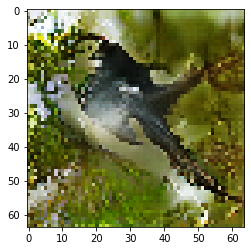

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 33

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 33.882325410842896 sec
Gen loss: 1.4676529715054727, Gen valid loss: 1.4290962143319086, Gen attr loss: 0.03925163251910708, Disc valid loss: 1.036818396592851, Disc valid real loss: 0.5252509295617339, Disc valid fake loss: 0.5115674670311171, Disc attr loss: 0.8120942293013624, Disc attr real loss: 0.7728425967822553, Disc attr fake loss: 0.03925163251910708
Time for epoch 2 is 34.147862672805786 sec
Gen loss: 1.4532794115666128, Gen valid loss: 1.4260221595363565, Gen attr loss: 0.027956235887561798, Disc valid loss: 1.0259857877160152, Disc valid real loss: 0.523136440573669, Disc valid fake loss: 0.5028493483538227, Disc attr loss: 0.7971704277023101, Disc attr real loss: 0.7692141918147483, Disc attr fake loss: 0.027956235887561798
Time for epoch 3 is 33.9727623462677 sec
Gen loss: 1.45355889403077, Gen valid loss: 1.4198965790472056, Gen attr l

Time for epoch 23 is 34.00063347816467 sec
Gen loss: 1.4633681050484098, Gen valid loss: 1.4337041575088088, Gen attr loss: 0.030365567157425097, Disc valid loss: 1.032145179384123, Disc valid real loss: 0.5268565094083305, Disc valid fake loss: 0.5052886689258461, Disc attr loss: 0.8026900866265881, Disc attr real loss: 0.7723245194691629, Disc attr fake loss: 0.030365567157425097
Time for epoch 24 is 34.01062536239624 sec
Gen loss: 1.45083910307587, Gen valid loss: 1.419483922038298, Gen attr loss: 0.0320488492049325, Disc valid loss: 1.0266992759898426, Disc valid real loss: 0.523255149361887, Disc valid fake loss: 0.5034441267894859, Disc attr loss: 0.8015497771995004, Disc attr real loss: 0.7695009279945678, Disc attr fake loss: 0.0320488492049325
Time for epoch 25 is 33.905797719955444 sec
Gen loss: 1.4531560913334047, Gen valid loss: 1.4224657605334026, Gen attr loss: 0.031385822027681184, Disc valid loss: 1.0301422486460305, Disc valid real loss: 0.5260520560470053, Disc valid 

Time for epoch 45 is 34.03212261199951 sec
Gen loss: 1.456846624532043, Gen valid loss: 1.4248872648086652, Gen attr loss: 0.03265542566259429, Disc valid loss: 1.025466579893417, Disc valid real loss: 0.5230029173659761, Disc valid fake loss: 0.5024636636581524, Disc attr loss: 0.8023401466388372, Disc attr real loss: 0.7696847209762429, Disc attr fake loss: 0.03265542566259429
Time for epoch 46 is 33.79663395881653 sec
Gen loss: 1.4761535536629076, Gen valid loss: 1.4455634659221825, Gen attr loss: 0.03129716914928433, Disc valid loss: 1.0254609400663919, Disc valid real loss: 0.5228415528933207, Disc valid fake loss: 0.5026193865269504, Disc attr loss: 0.8021647164371348, Disc attr real loss: 0.7708675472878506, Disc attr fake loss: 0.03129716914928433
Time for epoch 47 is 34.120349168777466 sec
Gen loss: 1.4641912726528923, Gen valid loss: 1.4308352525318218, Gen attr loss: 0.0340543635562833, Disc valid loss: 1.0288249751739709, Disc valid real loss: 0.5281983517857425, Disc valid

Time for epoch 67 is 33.855459690093994 sec
Gen loss: 1.4498361949998189, Gen valid loss: 1.4199499063052459, Gen attr loss: 0.030580922259968252, Disc valid loss: 1.0357244108427508, Disc valid real loss: 0.5321924520863427, Disc valid fake loss: 0.5035319577064618, Disc attr loss: 0.7959291411057725, Disc attr real loss: 0.7653482188458042, Disc attr fake loss: 0.030580922259968252
Time for epoch 68 is 34.13839864730835 sec
Gen loss: 1.4455401839279547, Gen valid loss: 1.413911212104446, Gen attr loss: 0.03231972161832077, Disc valid loss: 1.0369405638234725, Disc valid real loss: 0.5344880140893827, Disc valid fake loss: 0.5024525480380226, Disc attr loss: 0.7978106458158046, Disc attr real loss: 0.7654909241974839, Disc attr fake loss: 0.03231972161832077
Time for epoch 69 is 33.884525537490845 sec
Gen loss: 1.4624328506671316, Gen valid loss: 1.4307430562611194, Gen attr loss: 0.032388923282258175, Disc valid loss: 1.0283691650483666, Disc valid real loss: 0.5234430343478029, Disc

Time for epoch 89 is 33.911766052246094 sec
Gen loss: 1.4524763441344264, Gen valid loss: 1.422001762118766, Gen attr loss: 0.0311699497856912, Disc valid loss: 1.0294732087995948, Disc valid real loss: 0.5253264696455906, Disc valid fake loss: 0.504146740688541, Disc attr loss: 0.7929006806423514, Disc attr real loss: 0.7617307308566602, Disc attr fake loss: 0.0311699497856912
Time for epoch 90 is 33.64633512496948 sec
Gen loss: 1.45386937866366, Gen valid loss: 1.4237750836504184, Gen attr loss: 0.030790737600296516, Disc valid loss: 1.0325632946601082, Disc valid real loss: 0.5291257484495479, Disc valid fake loss: 0.5034375455644395, Disc attr loss: 0.7951353400197284, Disc attr real loss: 0.7643446024194319, Disc attr fake loss: 0.030790737600296516
Time for epoch 91 is 34.06888461112976 sec
Gen loss: 1.4460662748755477, Gen valid loss: 1.4170168437931918, Gen attr loss: 0.02974301926650578, Disc valid loss: 1.0339893084877552, Disc valid real loss: 0.5271624880754527, Disc valid 

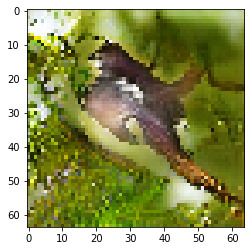

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 34

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 33.53131055831909 sec
Gen loss: 1.443566750220167, Gen valid loss: 1.414906562828436, Gen attr loss: 0.029352913703322422, Disc valid loss: 1.0460333354104825, Disc valid real loss: 0.5299658138092941, Disc valid fake loss: 0.5160675217627186, Disc attr loss: 0.7922375194095451, Disc attr real loss: 0.7628846057062226, Disc attr fake loss: 0.029352913703322422
Time for epoch 2 is 33.420491218566895 sec
Gen loss: 1.4490038980313433, Gen valid loss: 1.424285495830422, Gen attr loss: 0.02541778466748001, Disc valid loss: 1.0228240885708713, Disc valid real loss: 0.5236994120971297, Disc valid fake loss: 0.4991246756660906, Disc attr loss: 0.7882597059368891, Disc attr real loss: 0.7628419212694091, Disc attr fake loss: 0.02541778466748001
Time for epoch 3 is 33.67942786216736 sec
Gen loss: 1.443710467841244, Gen valid loss: 1.4119139602836879, Gen attr l

Time for epoch 23 is 33.51433038711548 sec
Gen loss: 1.4563595518510193, Gen valid loss: 1.431475264916252, Gen attr loss: 0.025587180203213315, Disc valid loss: 1.0284946523707734, Disc valid real loss: 0.5249913822667709, Disc valid fake loss: 0.5035032706693582, Disc attr loss: 0.784253422002157, Disc attr real loss: 0.7586662417989436, Disc attr fake loss: 0.025587180203213315
Time for epoch 24 is 33.42685866355896 sec
Gen loss: 1.4462213496851728, Gen valid loss: 1.4152951839816603, Gen attr loss: 0.03161795745537316, Disc valid loss: 1.0348075996569501, Disc valid real loss: 0.5314036168380158, Disc valid fake loss: 0.503403984999592, Disc attr loss: 0.7899663798176025, Disc attr real loss: 0.7583484223622293, Disc attr fake loss: 0.03161795745537316
Time for epoch 25 is 33.3665246963501 sec
Gen loss: 1.472825138872555, Gen valid loss: 1.4444262564666872, Gen attr loss: 0.029106494364358134, Disc valid loss: 1.0193246141035706, Disc valid real loss: 0.5211705839246269, Disc valid

Time for epoch 45 is 33.35128569602966 sec
Gen loss: 1.4534015158004554, Gen valid loss: 1.4242108746918882, Gen attr loss: 0.02988775235632791, Disc valid loss: 1.0284871494543908, Disc valid real loss: 0.5247449071265171, Disc valid fake loss: 0.5037422416817529, Disc attr loss: 0.7871271497393226, Disc attr real loss: 0.7572393973829946, Disc attr fake loss: 0.02988775235632791
Time for epoch 46 is 33.335840702056885 sec
Gen loss: 1.4727656411607737, Gen valid loss: 1.4457436386485734, Gen attr loss: 0.027730961854553392, Disc valid loss: 1.0272323988317473, Disc valid real loss: 0.5166517960508341, Disc valid fake loss: 0.5105806003579603, Disc attr loss: 0.7877279885616522, Disc attr real loss: 0.7599970267070988, Disc attr fake loss: 0.027730961854553392
Time for epoch 47 is 33.3587064743042 sec
Gen loss: 1.4570341320218756, Gen valid loss: 1.4238327063196075, Gen attr loss: 0.033896348881351485, Disc valid loss: 1.031804639472548, Disc valid real loss: 0.5283677351022478, Disc v

Time for epoch 67 is 33.32066321372986 sec
Gen loss: 1.4614169019347607, Gen valid loss: 1.4334719736724688, Gen attr loss: 0.028647290813075127, Disc valid loss: 1.0260944196848365, Disc valid real loss: 0.5273812443098724, Disc valid fake loss: 0.49871317553649425, Disc attr loss: 0.7866181334594645, Disc attr real loss: 0.7579708426463895, Disc attr fake loss: 0.028647290813075127
Time for epoch 68 is 33.31538724899292 sec
Gen loss: 1.4557103790887973, Gen valid loss: 1.4255607890565867, Gen attr loss: 0.030846895933488393, Disc valid loss: 1.033903361012942, Disc valid real loss: 0.5296311193526921, Disc valid fake loss: 0.5042722410948942, Disc attr loss: 0.7882386916514152, Disc attr real loss: 0.7573917957179268, Disc attr fake loss: 0.030846895933488393
Time for epoch 69 is 33.32954716682434 sec
Gen loss: 1.4741181871755336, Gen valid loss: 1.4463177454180833, Gen attr loss: 0.028509297062112006, Disc valid loss: 1.0212614239069828, Disc valid real loss: 0.5192100714215742, Dis

Time for epoch 89 is 33.280086517333984 sec
Gen loss: 1.4672481739101049, Gen valid loss: 1.439574115967686, Gen attr loss: 0.028379604562638654, Disc valid loss: 1.025673750939408, Disc valid real loss: 0.519463539850421, Disc valid fake loss: 0.5062102114120473, Disc attr loss: 0.7845798741137737, Disc attr real loss: 0.7562002695511351, Disc attr fake loss: 0.028379604562638654
Time for epoch 90 is 33.26039695739746 sec
Gen loss: 1.4772894240330228, Gen valid loss: 1.4452754231649363, Gen attr loss: 0.03272022880884532, Disc valid loss: 1.0203222228582636, Disc valid real loss: 0.51885559872237, Disc valid fake loss: 0.501466626155021, Disc attr loss: 0.7854632632734023, Disc attr real loss: 0.752743034464557, Disc attr fake loss: 0.03272022880884532
Time for epoch 91 is 33.34601712226868 sec
Gen loss: 1.4605298862870792, Gen valid loss: 1.4262141322055806, Gen attr loss: 0.03501130555543919, Disc valid loss: 1.0323814706104557, Disc valid real loss: 0.5255399183206119, Disc valid f

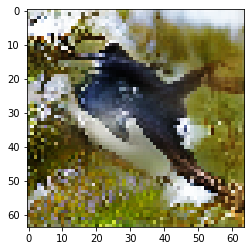

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 35

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 33.21592903137207 sec
Gen loss: 1.4645755399210343, Gen valid loss: 1.436015339078619, Gen attr loss: 0.029263525535509313, Disc valid loss: 1.0323225170939272, Disc valid real loss: 0.5260588483112615, Disc valid fake loss: 0.5062636703979678, Disc attr loss: 0.7851213206085972, Disc attr real loss: 0.7558577950730879, Disc attr fake loss: 0.029263525535509313
Time for epoch 2 is 33.32856106758118 sec
Gen loss: 1.4569667571282323, Gen valid loss: 1.4273238686042102, Gen attr loss: 0.030341331334222447, Disc valid loss: 1.0284013218349881, Disc valid real loss: 0.526687665521937, Disc valid fake loss: 0.5017136559899906, Disc attr loss: 0.7870489545313567, Disc attr real loss: 0.7567076231971342, Disc attr fake loss: 0.030341331334222447
Time for epoch 3 is 33.26788258552551 sec
Gen loss: 1.4683260433072967, Gen valid loss: 1.4358998766436486, Gen att

Time for epoch 23 is 33.19237542152405 sec
Gen loss: 1.440227784438508, Gen valid loss: 1.409693329637936, Gen attr loss: 0.03122364391689245, Disc valid loss: 1.0407541468537598, Disc valid real loss: 0.5335551316176004, Disc valid fake loss: 0.5071990158822801, Disc attr loss: 0.7792247328578927, Disc attr real loss: 0.7480010889410004, Disc attr fake loss: 0.03122364391689245
Time for epoch 24 is 33.222561836242676 sec
Gen loss: 1.4609306236592734, Gen valid loss: 1.4280429371004182, Gen attr loss: 0.033584869601656776, Disc valid loss: 1.0282523793579763, Disc valid real loss: 0.5252842311936665, Disc valid fake loss: 0.5029681484066051, Disc attr loss: 0.7872950775020374, Disc attr real loss: 0.7537102079003807, Disc attr fake loss: 0.033584869601656776
Time for epoch 25 is 33.17482304573059 sec
Gen loss: 1.4594146556001368, Gen valid loss: 1.4236850173169682, Gen attr loss: 0.036423220475779165, Disc valid loss: 1.0314602317202706, Disc valid real loss: 0.5301978102705989, Disc v

Time for epoch 45 is 33.20634174346924 sec
Gen loss: 1.4570230197131149, Gen valid loss: 1.4300605010210983, Gen attr loss: 0.02766366933926594, Disc valid loss: 1.02279252185408, Disc valid real loss: 0.5186498133632226, Disc valid fake loss: 0.5041427092985086, Disc attr loss: 0.7759820902592114, Disc attr real loss: 0.7483184209199456, Disc attr fake loss: 0.02766366933926594
Time for epoch 46 is 33.20848846435547 sec
Gen loss: 1.467897138621426, Gen valid loss: 1.439704952201223, Gen attr loss: 0.028897538875913873, Disc valid loss: 1.0300165539188437, Disc valid real loss: 0.5259650285812575, Disc valid fake loss: 0.5040515288912507, Disc attr loss: 0.7782781223192067, Disc attr real loss: 0.7493805834432927, Disc attr fake loss: 0.028897538875913873
Time for epoch 47 is 33.16149711608887 sec
Gen loss: 1.4725714017382159, Gen valid loss: 1.4458292561171824, Gen attr loss: 0.027451283523088014, Disc valid loss: 1.0221372371120505, Disc valid real loss: 0.5230951739682091, Disc vali

Time for epoch 67 is 33.2609703540802 sec
Gen loss: 1.478973164791014, Gen valid loss: 1.4476330645362212, Gen attr loss: 0.03204784352711725, Disc valid loss: 1.027687046262953, Disc valid real loss: 0.523039542320298, Disc valid fake loss: 0.5046475019235275, Disc attr loss: 0.7805053827782974, Disc attr real loss: 0.7484575392511802, Disc attr fake loss: 0.03204784352711725
Time for epoch 68 is 33.105555057525635 sec
Gen loss: 1.4582264639820832, Gen valid loss: 1.4264753834018862, Gen attr loss: 0.03244804956536836, Disc valid loss: 1.030606626333583, Disc valid real loss: 0.526379912687834, Disc valid fake loss: 0.5042267138880443, Disc attr loss: 0.7828256594873562, Disc attr real loss: 0.7503776099219878, Disc attr fake loss: 0.03244804956536836
Time for epoch 69 is 33.109025716781616 sec
Gen loss: 1.4592905554991105, Gen valid loss: 1.4204503743629144, Gen attr loss: 0.03953059669698351, Disc valid loss: 1.0319438193871724, Disc valid real loss: 0.5264036397785352, Disc valid f

Time for epoch 89 is 33.10028028488159 sec
Gen loss: 1.4526952766790622, Gen valid loss: 1.4270161399996377, Gen attr loss: 0.026379397826076883, Disc valid loss: 1.0273438553176921, Disc valid real loss: 0.5234067682328263, Disc valid fake loss: 0.5039370869233356, Disc attr loss: 0.7709298378322167, Disc attr real loss: 0.7445504400061398, Disc attr fake loss: 0.026379397826076883
Time for epoch 90 is 33.091508865356445 sec
Gen loss: 1.4527650483578525, Gen valid loss: 1.428393946107487, Gen attr loss: 0.02507271477803045, Disc valid loss: 1.0279968808983078, Disc valid real loss: 0.522112814714592, Disc valid fake loss: 0.5058840658606553, Disc attr loss: 0.7698956528842779, Disc attr real loss: 0.7448229381062474, Disc attr fake loss: 0.02507271477803045
Time for epoch 91 is 33.075395345687866 sec
Gen loss: 1.4504401363977573, Gen valid loss: 1.4214377257882096, Gen attr loss: 0.02969823336153211, Disc valid loss: 1.0356623892215533, Disc valid real loss: 0.5278676926766631, Disc v

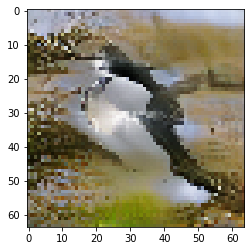

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 36

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 33.04938721656799 sec
Gen loss: 1.4636259599106745, Gen valid loss: 1.4296833990712152, Gen attr loss: 0.034640032832153694, Disc valid loss: 1.0312786622422174, Disc valid real loss: 0.5263080696264902, Disc valid fake loss: 0.5049705897889486, Disc attr loss: 0.7786670590518965, Disc attr real loss: 0.7440270262197427, Disc attr fake loss: 0.034640032832153694
Time for epoch 2 is 32.92328715324402 sec
Gen loss: 1.4678589926179508, Gen valid loss: 1.4376066609772886, Gen attr loss: 0.03095560684123554, Disc valid loss: 1.0262308380791165, Disc valid real loss: 0.5273360311985016, Disc valid fake loss: 0.49889480809209147, Disc attr loss: 0.7755246106251491, Disc attr real loss: 0.7445690037839134, Disc attr fake loss: 0.03095560684123554
Time for epoch 3 is 33.10070514678955 sec
Gen loss: 1.4655784320055953, Gen valid loss: 1.429596667690329, Gen att

Time for epoch 23 is 33.01353883743286 sec
Gen loss: 1.4486636941025897, Gen valid loss: 1.4183498779286536, Gen attr loss: 0.031007435510009347, Disc valid loss: 1.0366393264716234, Disc valid real loss: 0.5282482182591911, Disc valid fake loss: 0.5083911078893718, Disc attr loss: 0.7789046370280654, Disc attr real loss: 0.7478972015180562, Disc attr fake loss: 0.031007435510009347
Time for epoch 24 is 32.98501372337341 sec
Gen loss: 1.471831691943533, Gen valid loss: 1.4441240024437427, Gen attr loss: 0.028415499484595964, Disc valid loss: 1.0206973782076745, Disc valid real loss: 0.5273448556742371, Disc valid fake loss: 0.4933525230987931, Disc attr loss: 0.7747958957324752, Disc attr real loss: 0.7463803962478793, Disc attr fake loss: 0.028415499484595964
Time for epoch 25 is 33.124977827072144 sec
Gen loss: 1.456367855957207, Gen valid loss: 1.4235310292825467, Gen attr loss: 0.03353177731732158, Disc valid loss: 1.033197378563041, Disc valid real loss: 0.5250880594660596, Disc v

Time for epoch 45 is 32.97825813293457 sec
Gen loss: 1.46204329893841, Gen valid loss: 1.438520880572518, Gen attr loss: 0.024229512518210886, Disc valid loss: 1.022119953703428, Disc valid real loss: 0.5243857586125371, Disc valid fake loss: 0.4977341953331862, Disc attr loss: 0.7648310471629736, Disc attr real loss: 0.7406015346447626, Disc attr fake loss: 0.024229512518210886
Time for epoch 46 is 32.9632031917572 sec
Gen loss: 1.4510188645463649, Gen valid loss: 1.415604163314592, Gen attr loss: 0.03610440172868967, Disc valid loss: 1.0427602889738108, Disc valid real loss: 0.5314887376820169, Disc valid fake loss: 0.5112715499187873, Disc attr loss: 0.7747654459024602, Disc attr real loss: 0.7386610441737704, Disc attr fake loss: 0.03610440172868967
Time for epoch 47 is 33.014055490493774 sec
Gen loss: 1.4726055233782223, Gen valid loss: 1.443681528574729, Gen attr loss: 0.02963096840421781, Disc valid loss: 1.022804064802361, Disc valid real loss: 0.5212021096127466, Disc valid fa

Time for epoch 67 is 32.97369122505188 sec
Gen loss: 1.4530801110797458, Gen valid loss: 1.4237154605912, Gen attr loss: 0.030061428996946256, Disc valid loss: 1.0270122031209268, Disc valid real loss: 0.5268906984064314, Disc valid fake loss: 0.5001215044722002, Disc attr loss: 0.7690583841112746, Disc attr real loss: 0.7389969551143284, Disc attr fake loss: 0.030061428996946256
Time for epoch 68 is 32.95795965194702 sec
Gen loss: 1.4719483958996409, Gen valid loss: 1.4437895761272772, Gen attr loss: 0.02886623122948348, Disc valid loss: 1.029128567151584, Disc valid real loss: 0.5259018252050973, Disc valid fake loss: 0.5032267429964329, Disc attr loss: 0.7693293430920641, Disc attr real loss: 0.7404631118625806, Disc attr fake loss: 0.02886623122948348
Time for epoch 69 is 32.969669580459595 sec
Gen loss: 1.44396498371269, Gen valid loss: 1.4135525417198658, Gen attr loss: 0.031103619672987727, Disc valid loss: 1.0323329832818773, Disc valid real loss: 0.524308929275368, Disc valid 

Time for epoch 89 is 32.93429231643677 sec
Gen loss: 1.440386943054716, Gen valid loss: 1.4143744631188349, Gen attr loss: 0.026706261535290914, Disc valid loss: 1.0353881080299212, Disc valid real loss: 0.5294999888111259, Disc valid fake loss: 0.5058881160689563, Disc attr loss: 0.7622823153187904, Disc attr real loss: 0.7355760537834994, Disc attr fake loss: 0.026706261535290914
Time for epoch 90 is 32.934454917907715 sec
Gen loss: 1.439627723642158, Gen valid loss: 1.407166351470844, Gen attr loss: 0.03314833489695559, Disc valid loss: 1.039406083140593, Disc valid real loss: 0.5333491707558877, Disc valid fake loss: 0.5060569102848126, Disc attr loss: 0.7710730749788358, Disc attr real loss: 0.7379247400818801, Disc attr fake loss: 0.03314833489695559
Time for epoch 91 is 32.98319721221924 sec
Gen loss: 1.444347655870081, Gen valid loss: 1.4155156315180668, Gen attr loss: 0.0295249721723503, Disc valid loss: 1.0427215012108408, Disc valid real loss: 0.5347413957765109, Disc valid 

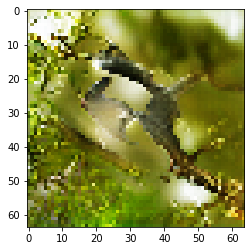

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 37

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 32.96334981918335 sec
Gen loss: 1.4649583899231784, Gen valid loss: 1.434460320123812, Gen attr loss: 0.031199653535218565, Disc valid loss: 1.034383914981108, Disc valid real loss: 0.5315398733790327, Disc valid fake loss: 0.5028440410367195, Disc attr loss: 0.7649733445949928, Disc attr real loss: 0.7337736910597742, Disc attr fake loss: 0.031199653535218565
Time for epoch 2 is 32.97570466995239 sec
Gen loss: 1.4605197163455208, Gen valid loss: 1.4340086322489793, Gen attr loss: 0.0272144342551131, Disc valid loss: 1.0253788565555562, Disc valid real loss: 0.5210053323891751, Disc valid fake loss: 0.504373523277965, Disc attr loss: 0.7628681507504796, Disc attr real loss: 0.7356537164953666, Disc attr fake loss: 0.0272144342551131
Time for epoch 3 is 32.97101092338562 sec
Gen loss: 1.4716003406338576, Gen valid loss: 1.4406606152774841, Gen attr los

Time for epoch 23 is 32.95625019073486 sec
Gen loss: 1.4723011368335424, Gen valid loss: 1.4385665971735306, Gen attr loss: 0.03443655425234704, Disc valid loss: 1.0289862886030823, Disc valid real loss: 0.5236702944205059, Disc valid fake loss: 0.5053159960401736, Disc attr loss: 0.7667506831757308, Disc attr real loss: 0.7323141289233839, Disc attr fake loss: 0.03443655425234704
Time for epoch 24 is 32.99281620979309 sec
Gen loss: 1.453597539808692, Gen valid loss: 1.4228045523651247, Gen attr loss: 0.03148859907124919, Disc valid loss: 1.0300502462115715, Disc valid real loss: 0.5228072681885748, Disc valid fake loss: 0.5072429796382987, Disc attr loss: 0.7636440836703989, Disc attr real loss: 0.7321554845991497, Disc attr fake loss: 0.03148859907124919
Time for epoch 25 is 32.89329171180725 sec
Gen loss: 1.4845156911912003, Gen valid loss: 1.4524481548526422, Gen attr loss: 0.0327773207330491, Disc valid loss: 1.0192047292947124, Disc valid real loss: 0.5226807610452336, Disc valid

Time for epoch 45 is 32.94242763519287 sec
Gen loss: 1.4549681671912753, Gen valid loss: 1.4303313671411861, Gen attr loss: 0.02533924600121256, Disc valid loss: 1.0236648854201402, Disc valid real loss: 0.5217716731837772, Disc valid fake loss: 0.5018932140131953, Disc attr loss: 0.7568349866151758, Disc attr real loss: 0.7314957406139633, Disc attr fake loss: 0.02533924600121256
Time for epoch 46 is 32.892324447631836 sec
Gen loss: 1.4648801666611255, Gen valid loss: 1.4365527604007462, Gen attr loss: 0.029031116342923935, Disc valid loss: 1.0308028448241835, Disc valid real loss: 0.5308474983949325, Disc valid fake loss: 0.4999553473984323, Disc attr loss: 0.7602835317363502, Disc attr real loss: 0.7312524153934261, Disc attr fake loss: 0.029031116342923935
Time for epoch 47 is 32.88485336303711 sec
Gen loss: 1.48207314486103, Gen valid loss: 1.4483582592268947, Gen attr loss: 0.03442180713517155, Disc valid loss: 1.0231991537864291, Disc valid real loss: 0.5207698998573996, Disc va

Time for epoch 67 is 32.93633246421814 sec
Gen loss: 1.4693422207664344, Gen valid loss: 1.4394723535553227, Gen attr loss: 0.030574271058131593, Disc valid loss: 1.0229496174065402, Disc valid real loss: 0.5230443463900548, Disc valid fake loss: 0.4999052722279618, Disc attr loss: 0.7596255513301708, Disc attr real loss: 0.7290512802720392, Disc attr fake loss: 0.030574271058131593
Time for epoch 68 is 32.87418484687805 sec
Gen loss: 1.4656366326298493, Gen valid loss: 1.4401874936370023, Gen attr loss: 0.026156107065265024, Disc valid loss: 1.03118951485409, Disc valid real loss: 0.5251088614063211, Disc valid fake loss: 0.5060806532054736, Disc attr loss: 0.754523265961012, Disc attr real loss: 0.7283671588957471, Disc attr fake loss: 0.026156107065265024
Time for epoch 69 is 32.88450813293457 sec
Gen loss: 1.4726065112969418, Gen valid loss: 1.4506845952372565, Gen attr loss: 0.02263588930826635, Disc valid loss: 1.0196105768363974, Disc valid real loss: 0.5179731414570072, Disc va

Time for epoch 89 is 32.92408537864685 sec
Gen loss: 1.459744234395221, Gen valid loss: 1.425931429798364, Gen attr loss: 0.03450846934605339, Disc valid loss: 1.0316357166786505, Disc valid real loss: 0.5267500660929899, Disc valid fake loss: 0.5048856492934188, Disc attr loss: 0.7629094488097004, Disc attr real loss: 0.728400979463647, Disc attr fake loss: 0.03450846934605339
Time for epoch 90 is 32.74979519844055 sec
Gen loss: 1.4558706193112423, Gen valid loss: 1.4292785746618337, Gen attr loss: 0.02729298676929479, Disc valid loss: 1.0302637408419353, Disc valid real loss: 0.5285596911338609, Disc valid fake loss: 0.5017040529386784, Disc attr loss: 0.7558202094763145, Disc attr real loss: 0.7285272227070196, Disc attr fake loss: 0.02729298676929479
Time for epoch 91 is 32.88388633728027 sec
Gen loss: 1.468886541157234, Gen valid loss: 1.437055254047156, Gen attr loss: 0.03253349891012693, Disc valid loss: 1.0282426600856833, Disc valid real loss: 0.5252548393195238, Disc valid fa

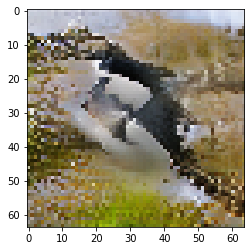

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 38

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 32.85422086715698 sec
Gen loss: 1.4420222182907063, Gen valid loss: 1.4150592082238134, Gen attr loss: 0.027656664247162375, Disc valid loss: 1.03768710860715, Disc valid real loss: 0.5279432142653117, Disc valid fake loss: 0.5097438949071941, Disc attr loss: 0.7553301810957085, Disc attr real loss: 0.7276735168485461, Disc attr fake loss: 0.027656664247162375
Time for epoch 2 is 32.879348278045654 sec
Gen loss: 1.4595113960385, Gen valid loss: 1.4353637349637867, Gen attr loss: 0.024852867183691296, Disc valid loss: 1.027465095688011, Disc valid real loss: 0.5276623389262171, Disc valid fake loss: 0.4998027550657267, Disc attr loss: 0.7523526216319385, Disc attr real loss: 0.7274997544482471, Disc attr fake loss: 0.024852867183691296
Time for epoch 3 is 32.83168292045593 sec
Gen loss: 1.459726437966675, Gen valid loss: 1.4322590275508602, Gen attr lo

Time for epoch 23 is 32.844680309295654 sec
Gen loss: 1.459687430361099, Gen valid loss: 1.427616515779883, Gen attr loss: 0.03276829393380399, Disc valid loss: 1.032302709452828, Disc valid real loss: 0.5243988339170854, Disc valid fake loss: 0.5079038766664541, Disc attr loss: 0.7607623948892477, Disc attr real loss: 0.7279941009554437, Disc attr fake loss: 0.03276829393380399
Time for epoch 24 is 32.85970211029053 sec
Gen loss: 1.4549795809153943, Gen valid loss: 1.4248803685997238, Gen attr loss: 0.03079620640597698, Disc valid loss: 1.034269454679515, Disc valid real loss: 0.5279593773004485, Disc valid fake loss: 0.5063100766521805, Disc attr loss: 0.7595770958605498, Disc attr real loss: 0.7287808894545729, Disc attr fake loss: 0.03079620640597698
Time for epoch 25 is 32.830413579940796 sec
Gen loss: 1.475752105719352, Gen valid loss: 1.443807821932847, Gen attr loss: 0.0326498140511244, Disc valid loss: 1.0254400120518072, Disc valid real loss: 0.5203805870318478, Disc valid fa

Time for epoch 45 is 32.876627683639526 sec
Gen loss: 1.4762107353546432, Gen valid loss: 1.443981531189709, Gen attr loss: 0.032934680376279786, Disc valid loss: 1.0234491450353689, Disc valid real loss: 0.5213106612202921, Disc valid fake loss: 0.5021384829266607, Disc attr loss: 0.7565665912954538, Disc attr real loss: 0.7236319109191739, Disc attr fake loss: 0.032934680376279786
Time for epoch 46 is 32.86514663696289 sec
Gen loss: 1.4685189853192668, Gen valid loss: 1.4350034040487232, Gen attr loss: 0.03421592498052373, Disc valid loss: 1.0305494081360216, Disc valid real loss: 0.5225751495296717, Disc valid fake loss: 0.5079742591717056, Disc attr loss: 0.7600813146577678, Disc attr real loss: 0.7258653896772441, Disc attr fake loss: 0.03421592498052373
Time for epoch 47 is 32.869998931884766 sec
Gen loss: 1.4527066716656776, Gen valid loss: 1.421281743340376, Gen attr loss: 0.03211946120026981, Disc valid loss: 1.0297350849562543, Disc valid real loss: 0.5272623928904856, Disc v

Time for epoch 67 is 32.85218787193298 sec
Gen loss: 1.4645704497812886, Gen valid loss: 1.4318401857120235, Gen attr loss: 0.03342942002928017, Disc valid loss: 1.0249810243040565, Disc valid real loss: 0.5211195962700418, Disc valid fake loss: 0.5038614267417731, Disc attr loss: 0.7543521607659082, Disc attr real loss: 0.720922740736628, Disc attr fake loss: 0.03342942002928017
Time for epoch 68 is 32.83215856552124 sec
Gen loss: 1.4668552875518799, Gen valid loss: 1.4399522181125837, Gen attr loss: 0.027609191587784975, Disc valid loss: 1.0301430579123458, Disc valid real loss: 0.5246216433481149, Disc valid fake loss: 0.505521413837345, Disc attr loss: 0.7481075143418334, Disc attr real loss: 0.7204983227540483, Disc attr fake loss: 0.027609191587784975
Time for epoch 69 is 32.85858774185181 sec
Gen loss: 1.484863683783265, Gen valid loss: 1.4516286013249136, Gen attr loss: 0.033943874143570245, Disc valid loss: 1.0232287247975667, Disc valid real loss: 0.5233474503041606, Disc val

Time for epoch 89 is 32.91711926460266 sec
Gen loss: 1.473866217504672, Gen valid loss: 1.4397485420955876, Gen attr loss: 0.03482008707077671, Disc valid loss: 1.0240706549427374, Disc valid real loss: 0.5242394429396807, Disc valid fake loss: 0.4998312127299425, Disc attr loss: 0.7552045791275793, Disc attr real loss: 0.7203844920568027, Disc attr fake loss: 0.03482008707077671
Time for epoch 90 is 32.833672761917114 sec
Gen loss: 1.4739819765090942, Gen valid loss: 1.4368920626679087, Gen attr loss: 0.03778941539647213, Disc valid loss: 1.025766099210031, Disc valid real loss: 0.5223180276107012, Disc valid fake loss: 0.5034480743453431, Disc attr loss: 0.7593064586200211, Disc attr real loss: 0.721517043223549, Disc attr fake loss: 0.03778941539647213
Time for epoch 91 is 32.8945472240448 sec
Gen loss: 1.453384334317391, Gen valid loss: 1.4193897825592579, Gen attr loss: 0.034686854487655294, Disc valid loss: 1.037897510418724, Disc valid real loss: 0.5257412775099116, Disc valid f

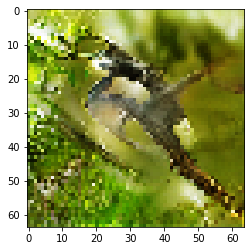

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 39

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 32.83602428436279 sec
Gen loss: 1.4597108231650457, Gen valid loss: 1.4285780879540173, Gen attr loss: 0.031831058376005514, Disc valid loss: 1.036135013187481, Disc valid real loss: 0.5252565600200074, Disc valid fake loss: 0.5108784513906411, Disc attr loss: 0.7499086867672274, Disc attr real loss: 0.7180776283912219, Disc attr fake loss: 0.031831058376005514
Time for epoch 2 is 32.81944966316223 sec
Gen loss: 1.47873122889175, Gen valid loss: 1.4432616799181393, Gen attr loss: 0.03617304494034493, Disc valid loss: 1.0206485545732142, Disc valid real loss: 0.5208859081029246, Disc valid fake loss: 0.49976264525881303, Disc attr loss: 0.7566198755002203, Disc attr real loss: 0.7204468305598752, Disc attr fake loss: 0.03617304494034493
Time for epoch 3 is 32.826085805892944 sec
Gen loss: 1.4709168326887012, Gen valid loss: 1.43496934072112, Gen attr l

Time for epoch 23 is 32.76601004600525 sec
Gen loss: 1.4677598486101724, Gen valid loss: 1.440813623792757, Gen attr loss: 0.02765275411625964, Disc valid loss: 1.029015638156312, Disc valid real loss: 0.5247787156402257, Disc valid fake loss: 0.5042369224353211, Disc attr loss: 0.7440857087981807, Disc attr real loss: 0.7164329546819211, Disc attr fake loss: 0.02765275411625964
Time for epoch 24 is 32.80592441558838 sec
Gen loss: 1.4724685069991321, Gen valid loss: 1.4393973218070135, Gen attr loss: 0.03377394695263021, Disc valid loss: 1.0230210544617195, Disc valid real loss: 0.5181829183889921, Disc valid fake loss: 0.504838138091855, Disc attr loss: 0.7535378482493001, Disc attr real loss: 0.7197639012966699, Disc attr fake loss: 0.03377394695263021
Time for epoch 25 is 32.77451419830322 sec
Gen loss: 1.4600679063538549, Gen valid loss: 1.4256486556717374, Gen attr loss: 0.03511447031455025, Disc valid loss: 1.0332747311773016, Disc valid real loss: 0.5244495345325004, Disc valid 

Time for epoch 45 is 32.81985354423523 sec
Gen loss: 1.4825891343558706, Gen valid loss: 1.4563515347840017, Gen attr loss: 0.02695224538793324, Disc valid loss: 1.0302779666453519, Disc valid real loss: 0.5212917233385691, Disc valid fake loss: 0.508986245083615, Disc attr loss: 0.7457129479753348, Disc attr real loss: 0.7187607025874017, Disc attr fake loss: 0.02695224538793324
Time for epoch 46 is 32.74062442779541 sec
Gen loss: 1.4512469254858125, Gen valid loss: 1.4270094768787787, Gen attr loss: 0.02493843399622023, Disc valid loss: 1.0332923922435377, Disc valid real loss: 0.5258986072004003, Disc valid fake loss: 0.5073937839931912, Disc attr loss: 0.7424785926466365, Disc attr real loss: 0.7175401586504163, Disc attr fake loss: 0.02493843399622023
Time for epoch 47 is 32.704869985580444 sec
Gen loss: 1.4634511477255885, Gen valid loss: 1.4325635258744402, Gen attr loss: 0.03158806140602075, Disc valid loss: 1.0260812481890527, Disc valid real loss: 0.5253184599281973, Disc val

Time for epoch 67 is 32.8109610080719 sec
Gen loss: 1.4559531224775444, Gen valid loss: 1.4284422846667488, Gen attr loss: 0.02821090065832666, Disc valid loss: 1.0333457550382226, Disc valid real loss: 0.5294761572911487, Disc valid fake loss: 0.5038695995239061, Disc attr loss: 0.7439859084593309, Disc attr real loss: 0.7157750078010042, Disc attr fake loss: 0.02821090065832666
Time for epoch 68 is 32.726906538009644 sec
Gen loss: 1.4593227281156917, Gen valid loss: 1.4297003700804258, Gen attr loss: 0.03032199759467967, Disc valid loss: 1.0306631838726157, Disc valid real loss: 0.5228298396922062, Disc valid fake loss: 0.5078333447457652, Disc attr loss: 0.7469880134238539, Disc attr real loss: 0.7166660158291742, Disc attr fake loss: 0.03032199759467967
Time for epoch 69 is 32.68289303779602 sec
Gen loss: 1.4625573885150072, Gen valid loss: 1.4369043367018868, Gen attr loss: 0.02635827640980354, Disc valid loss: 1.0245242076837597, Disc valid real loss: 0.524780679928255, Disc vali

Time for epoch 89 is 32.85371541976929 sec
Gen loss: 1.464878171763123, Gen valid loss: 1.4395196678515696, Gen attr loss: 0.026065177087399367, Disc valid loss: 1.0273708930506615, Disc valid real loss: 0.5245628131598961, Disc valid fake loss: 0.50280807948694, Disc attr loss: 0.7413790643362398, Disc attr real loss: 0.7153138872488405, Disc attr fake loss: 0.026065177087399367
Time for epoch 90 is 32.778730630874634 sec
Gen loss: 1.4615441767503898, Gen valid loss: 1.4347574804533465, Gen attr loss: 0.02749028197396995, Disc valid loss: 1.0310352257273707, Disc valid real loss: 0.5246107575854635, Disc valid fake loss: 0.506424463942122, Disc attr loss: 0.7438339833443333, Disc attr real loss: 0.7163437013703633, Disc attr fake loss: 0.02749028197396995
Time for epoch 91 is 32.82307457923889 sec
Gen loss: 1.470386245063327, Gen valid loss: 1.437539629496856, Gen attr loss: 0.03354855922738464, Disc valid loss: 1.0319171022916551, Disc valid real loss: 0.5205966879520313, Disc valid 

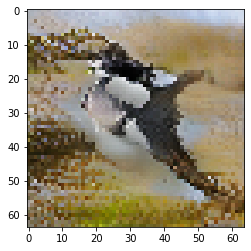

In [330]:
next_starting_checkpoint, totalepochs, warmup = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=20, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      g_valid_hist=gen_valid_loss_hist,
                                      g_attr_hist=gen_attr_loss_hist,
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      d_attr_real_hist=disc_attr_loss_real_hist,
                                      d_attr_fake_hist=disc_attr_loss_fake_hist,
                                      noise=noise300,
                                      attr=attr,
                                      save_files=True,
                                      warmup=warmup)

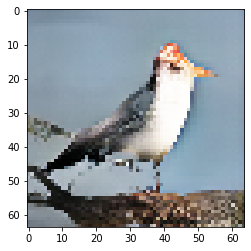

In [241]:
attrs = train_attrs[np.random.choice(range(len(train_attrs)), 1, replace=False)]
# attrs = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
for i in range(1):
    tempnoise = np.random.normal(0, 1, 300)

    
#     attrs[2] += 1.
    
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs[0]])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()
#     ax.imshow(unnormalize_img(generated_image))

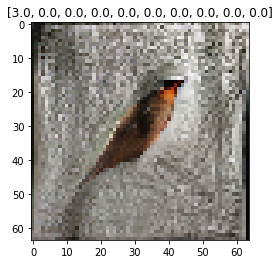

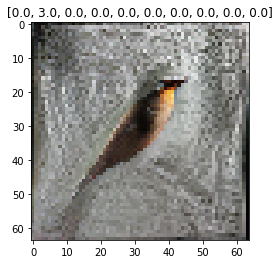

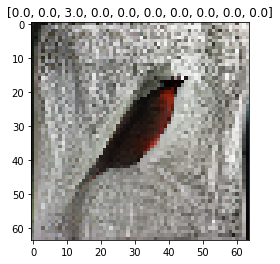

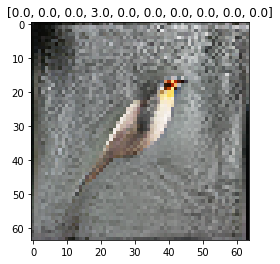

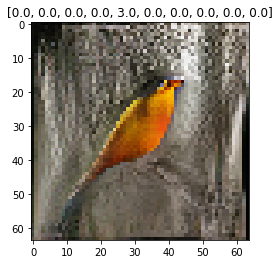

In [364]:
# noise = np.random.normal(0, 1, 300)
for i in range(5):
    attrs = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
#     attrs = np.round(np.random.uniform(0, 1, 10)) * 3
#     attrs[5] -= 1
    attrs[i] += 3
    generated_image = generator.predict([np.array([noise]), np.array([attrs])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.title(str(attrs))
    plt.show()
#     ax.imshow(unnormalize_img(generated_image))

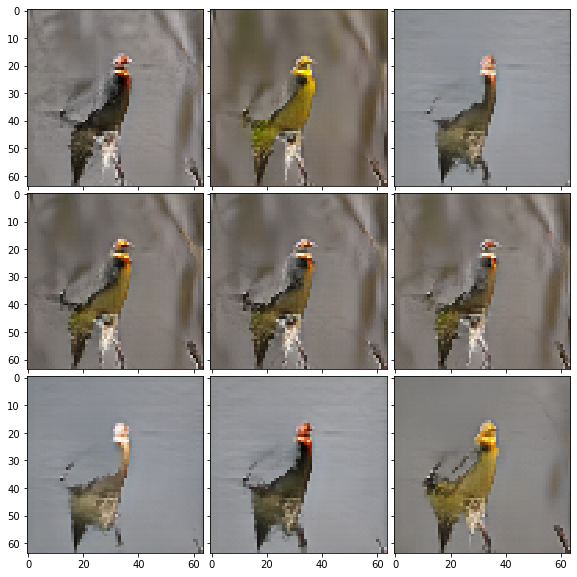

In [173]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

attrs = train_attrs[np.random.choice(range(len(train_attrs)), 9, replace=False)]
tempnoise = np.random.normal(0, 1, 300)
for i, ax in enumerate(grid):
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs[i]])] )[0]
    ax.imshow(unnormalize_img(generated_image))

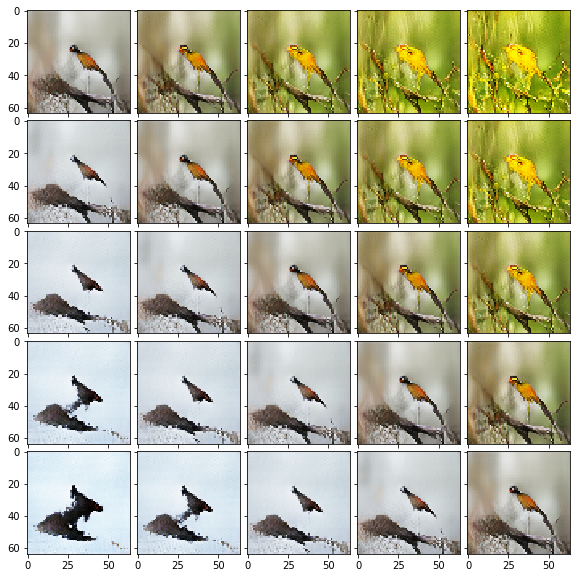

In [421]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),
                 axes_pad=0.1,  # pad between axes in inch.
                 )

attrs = train_attrs[np.random.choice(range(len(train_attrs)), 9, replace=False)]
for i, ax in enumerate(grid):
    attrs = [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]
    x = i % 5
    y = (i // 5) % 5
    attrs[8] = (3*x + 1.)
    attrs[9] = (3*y + 1.)
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs])] )[0]
    ax.imshow(unnormalize_img(generated_image))

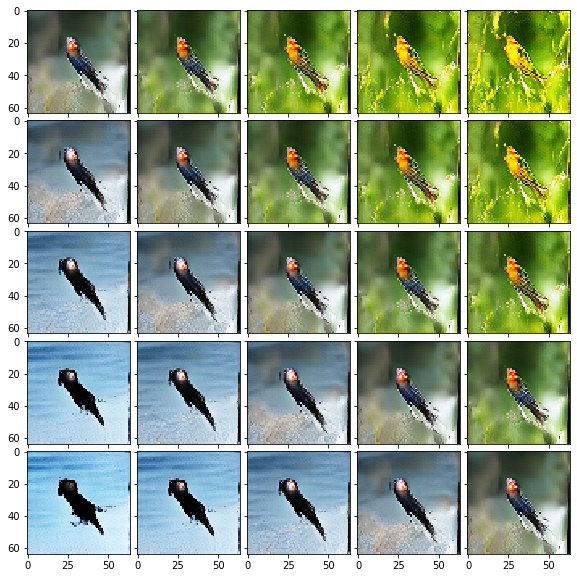

In [637]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),
                 axes_pad=0.1,  # pad between axes in inch.
                 )

attrs = train_attrs[np.random.choice(range(len(train_attrs)), 9, replace=False)]
for i, ax in enumerate(grid):
    attrs = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    x = i % 5
    y = (i // 5) % 5
    attrs[8] = (4*x)
    attrs[9] = (4*y)
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs])] )[0]
    ax.imshow(unnormalize_img(generated_image))

In [16]:
generator.load_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning/gen_weights_attributes_split_4000.h5')
discriminator_attr.load_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning/disc_weights_attributes_split_attr_4000.h5')
discriminator_valid.load_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning/disc_weights_attributes_split_valid_4000.h5')

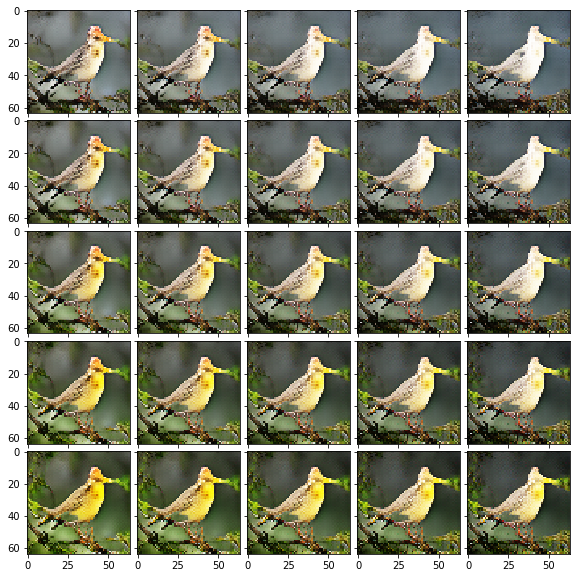

In [270]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),
                 axes_pad=0.1,  # pad between axes in inch.
                 )

attrs = train_attrs[np.random.choice(range(len(train_attrs)), 9, replace=False)]

for i, ax in enumerate(grid):
    attrs = [0., 0., 0., 0., 0., 3., 0., 3., 6., 0.]
    x = i % 5
    y = (i // 5) % 5
    attrs[3] = (1.*x)
    attrs[4] = (1.*y)
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs])] )[0]
    ax.imshow(unnormalize_img(generated_image))

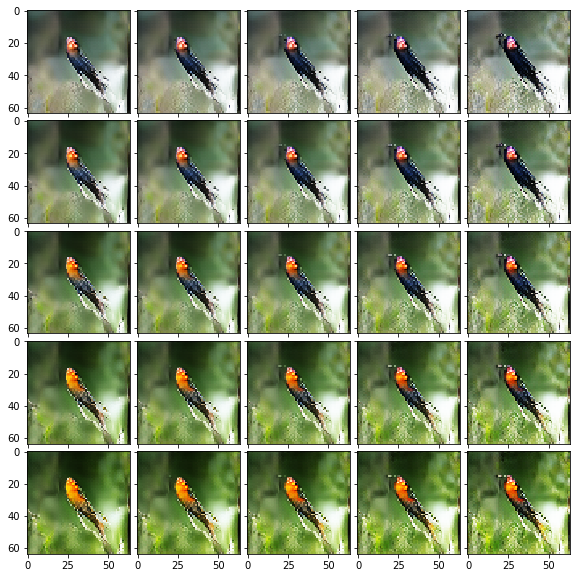

In [638]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 5),
                 axes_pad=0.1,  # pad between axes in inch.
                 )

attrs = train_attrs[np.random.choice(range(len(train_attrs)), 9, replace=False)]
for i, ax in enumerate(grid):
    attrs = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
    x = i % 5
    y = (i // 5) % 5
    attrs[2] = (x)
    attrs[4] = (y)
    generated_image = generator.predict([np.array([tempnoise]), np.array([attrs])] )[0]
    ax.imshow(unnormalize_img(generated_image))

In [636]:
savednoise = tempnoise.copy()
# tempnoise = savednoise.copy()

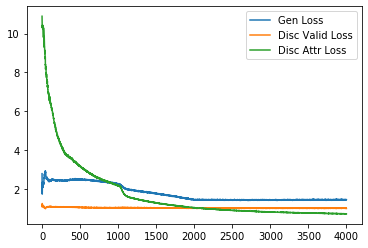

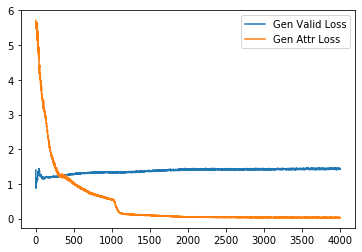

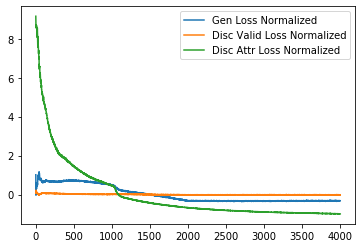

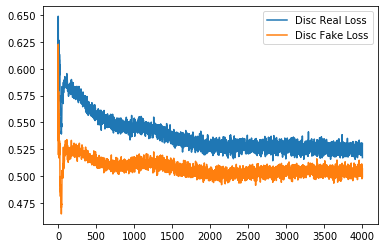

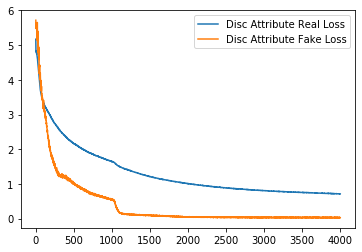

In [331]:
plot_save_dir = 'bird-gan-attributes-split-sigmoid-simple-tuning'

from operator import add
disc_attr_loss_hist = list( map(add, disc_attr_loss_real_hist, disc_attr_loss_fake_hist) )

plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)
plt.plot(disc_attr_loss_hist)

plt.legend(['Gen Loss','Disc Valid Loss', 'Disc Attr Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses.png')
plt.show()

plt.plot(gen_valid_loss_hist)
plt.plot(gen_attr_loss_hist)
plt.legend(['Gen Valid Loss', 'Gen Attr Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_valid_attr_losses.png')
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.plot(disc_attr_loss_hist - np.mean(disc_attr_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Valid Loss Normalized', 'Disc Attr Loss Normalized'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses_normalized.png')
plt.show()

plt.plot(disc_loss_real_hist)
plt.plot(disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/d_real_fake_losses.png')
plt.show()

plt.plot(disc_attr_loss_real_hist)
# plt.show()
plt.plot(disc_attr_loss_fake_hist)
plt.legend(['Disc Attribute Real Loss', 'Disc Attribute Fake Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/d_attribute_real_fake_losses.png')
plt.show()


In [15]:
generator.load_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning/gen_weights_attributes_split_2000.h5')

fid_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        im = cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR)
        im = cv2.resize(im, (75, 75))
        fid_imgs.append(im)

fid_imgs = np.array(fid_imgs)
fid_imgs = (fid_imgs - 127.5)/127.5

def generate_fake_images(model, samples, noise_dim):
    noise = np.random.normal(0, 1, (samples, noise_dim))
    imgs = model.predict([noise, train_attrs])
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(cv2.resize(img, (75, 75)))
    return np.array(resized_imgs)


from tensorflow.keras.applications.inception_v3 import InceptionV3
iv3 = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))

import scipy

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fids = 0
for i in range(5):
    fake_images = generate_fake_images(generator, len(fid_imgs), 300)
    fids += calculate_fid(iv3, fid_imgs, fake_images)
    print(f'{100*(i+1)/5.:.2f}%')
print(fids/5.)

20.00%
40.00%
60.00%
80.00%
100.00%
128.2204749055731


In [12]:
generator.load_weights('./results/weights/bird-gan-attributes-split-sigmoid-simple-tuning/gen_weights_attributes_split_2000.h5')

del train_imgs

fid_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        im = cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR)
        im = cv2.resize(im, (299, 299))
        fid_imgs.append(im)

fid_imgs = np.array(fid_imgs)
# fid_imgs = fid_imgs[:5000]
# fid_imgs = (fid_imgs - 127.5)/127.5

# train_attrs = train_attrs[:5000]

def generate_fake_images(model, samples, noise_dim):
    noise = np.random.normal(0, 1, (samples, noise_dim))
    imgs = model.predict([noise, train_attrs])
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(cv2.resize(unnormalize_img(img), (299, 299)))
    return np.round(255*np.array(resized_imgs))


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
iv3 = InceptionV3(include_top=False, pooling='avg')#, input_shape=(75,75,3))

import scipy

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fids = 0
for i in range(1):
    fake_images = generate_fake_images(generator, len(fid_imgs), 300)
    fids += calculate_fid(iv3, fid_imgs, fake_images)
    print(f'{100*(i+1)/5.:.2f}%')
print(fids/1.)

20.00%
52.63740174228618


In [271]:
d = dict.fromkeys([i for i in range(10)], 0)
prediction = discriminator_attr.predict(np.array(train_imgs))
prediction = np.round(prediction)
for p in prediction:
    p = np.where(p == 1)
    for i in p[0]:
        d[i] += 1
    
# for im in train_imgs:
#     for p in prediction[0]:
#         d[p] += 1

<BarContainer object of 10 artists>

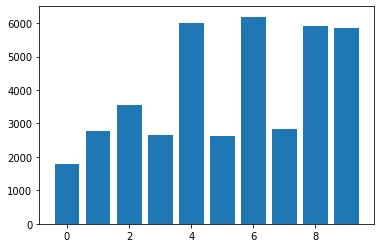

In [272]:
plt.bar([x for x in range(10)], d.values())